# pre

## import & setting

In [8]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import pandas as pd
import scipy.io as sio
import pickle
sc.set_figure_params(dpi=500, color_map='viridis')
sc.settings.verbosity = 2
%matplotlib inline


## functions

In [335]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [2]:
def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]



In [3]:
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4


    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



In [4]:
def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

In [5]:
def show_images(images, cols = 1, titles = None,cmps='jet'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
#         print(cols)
#         cmp = cmps[n]
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        
    
        plt.imshow(image,cmap=cmps)
        plt.xticks([])
        plt.yticks([])
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

import matplotlib.pyplot as plt
# uh_pred = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(rep_embed)
# pred_y = np.ones(shape=(np.max(cell_idx)))
# pred_y = KMeans(3).fit_predict(sim_mat_bak)
# pred_y = SIMLR(sim_mat_bak,-8)
# pred_y = SpectralClustering(4,affinity='precomputed').fit_predict(sim_mat_order_bak)
# pred_y = AgglomerativeClustering(4,affinity='precomputed',linkage='complete').fit_predict(1/(input_sim_mat+1))
def plot_label_image(pred_y,cmp,save=None,mask=None):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=(5,5))
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='pdf',bbox_inches='tight')

#     for i in range(num_cells):
#         cur_idx = i + 1
#         cur_ind = cell_pos[cell_idx==cur_idx][0]
#     #     print(ind2ij(cur_ind,256,0))
#     #     print(ind2ij(cur_ind,256,1))

#         plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')


    plt.show()


# experiment

## data loading

In [6]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'


# data='mouse0_liver0_neg1_high0_div15_None_ada'
# test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'
data = 'P6_neg1_low0_None_auto'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_228.mat'



matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']

In [11]:
a = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_c4.h5ad')
# f = open('figures/Fig4_dump_data/fig4_cluster4_add.pkl', 'rb') 
# a = pickle.load(f)

In [10]:
cls_4 = np.array(a.obs['pred'])
cls_4[cls_4=='4']='2'
cls_4[cls_4=='5']='4'
a.obs['cls_4'] = cls_4

## umap projection

In [111]:
cmp_5 = palettable.colorbrewer.qualitative.Set1_5.mpl_colors
# 0:红
# 1:蓝
# 2:绿
# 3:紫
# 4:黄

In [28]:
cur_cmp = [cmp_5[3],cmp_5[1],cmp_5[2],cmp_5[0]]

In [141]:
cur_cmp

[(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

In [29]:
a.uns['cls_4_colors'] = cur_cmp

In [13]:
a

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'SIMS-Cluster', 'fibro_dist', 'fibro_zonation'
    uns: 'SIMS-Cluster_colors', 'dendrogram_SIMS-Cluster', 'fibro_zonation_colors', 'rank_genes_groups', 'rep_list'
    obsm: 'X_umap', 'X_pca', 'spatial'

... storing 'cls_sub' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have 

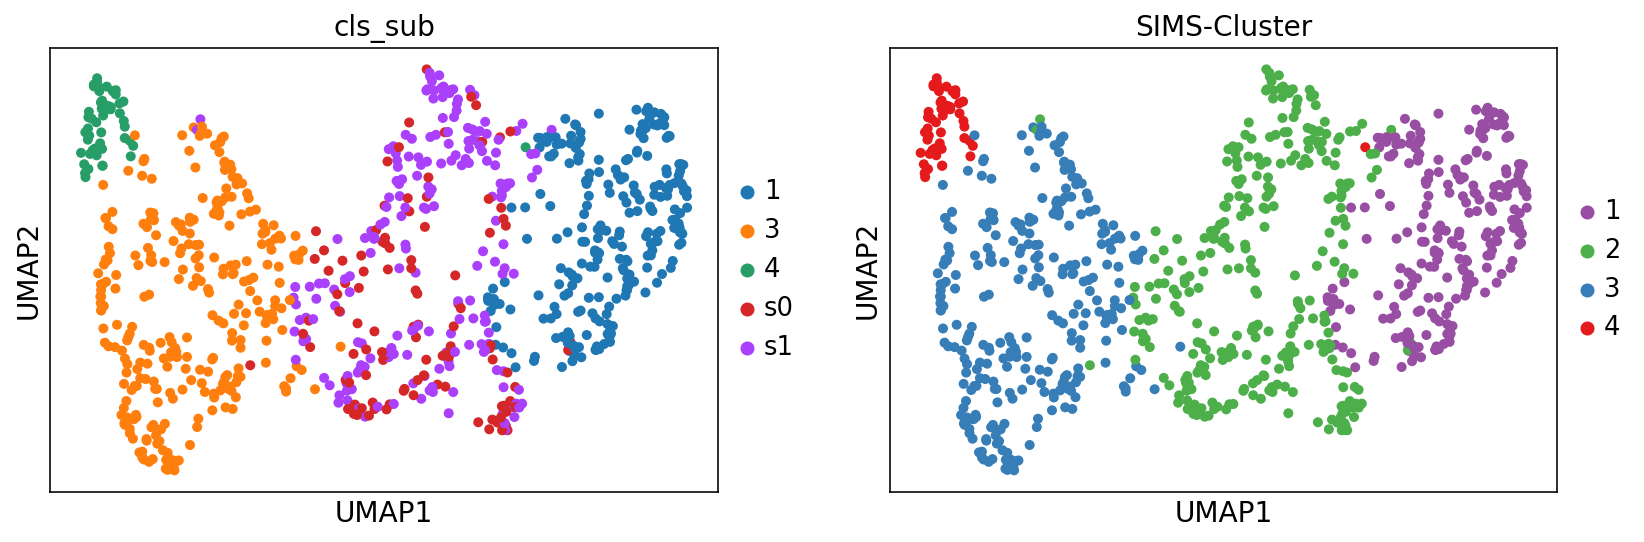

In [100]:
sc.pl.umap(a,color=['cls_sub','SIMS-Cluster'],save=None,s=100)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

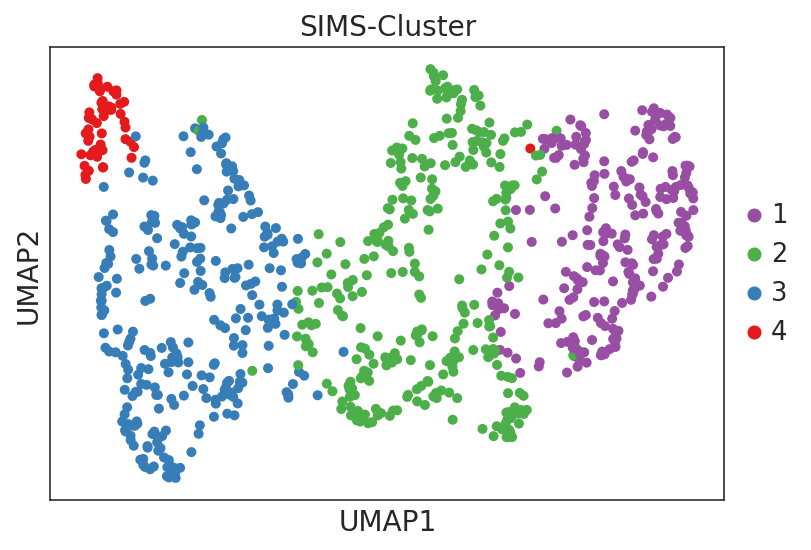

In [317]:
sc.pl.umap(a,color=['SIMS-Cluster'],save=None,s=100)

In [74]:
a_cls2 = a[a.obs['SIMS-Cluster']=='2']

In [75]:
a_cls2 = a_cls2[:,['91.33','77.31']]

In [152]:
sc.pp.neighbors(a_cls2,use_rep='spatial')
sc.tl.louvain(a_cls2,resolution=5)

computing neighbors
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [153]:
np.unique(a_cls2.obs['louvain'])

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

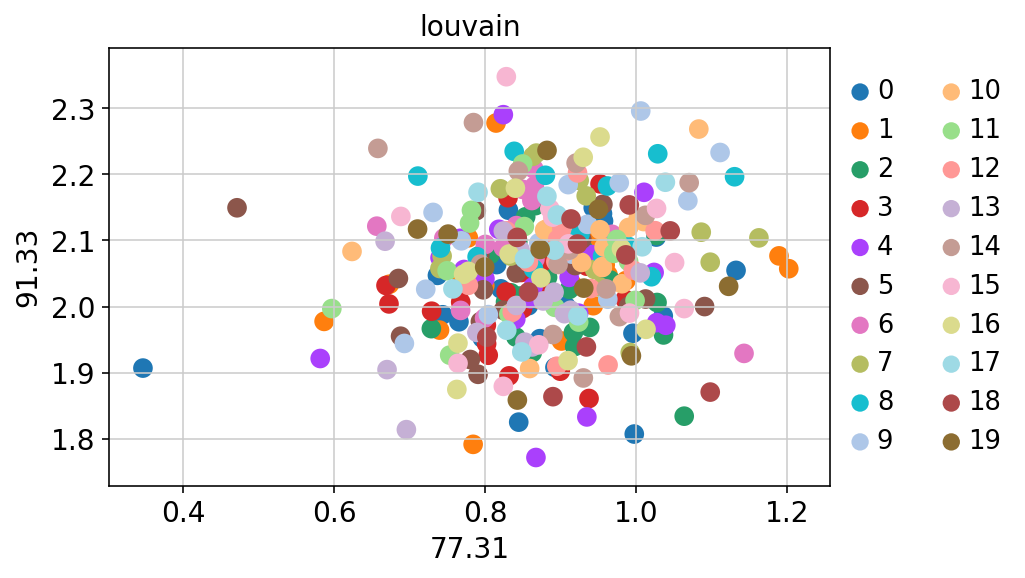

In [154]:
sc.pl.scatter(a_cls2,x='77.31',y='91.33',color='louvain',palette=sc.pl.palettes.vega_20_scanpy)

In [155]:
sc.tl.rank_genes_groups(a_cls2,groupby='louvain')

ranking genes
    finished (0:00:00)


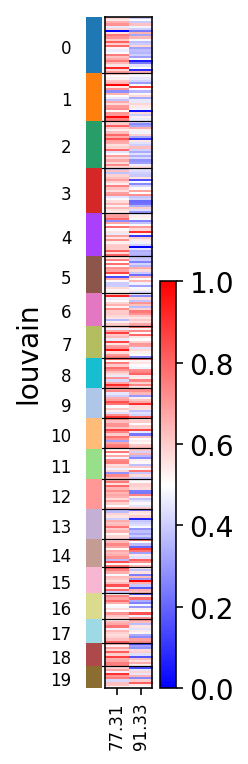

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 0.6, 0, 0.2])

In [156]:
# sc.pl.rank_genes_groups_heatmap(a_cls2)
sc.pl.heatmap(a_cls2, ['77.31','91.33'],groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False)


In [54]:
a.obs['cls_sub'] = np.array(a.obs['SIMS-Cluster'])

In [81]:
a_cls2.obs['spatial_x'] = a_cls2.obsm['spatial'][:,0]
a_cls2.obs['spatial_y'] = a_cls2.obsm['spatial'][:,1]

In [93]:
sub_cls2 = np.array(a_cls2.obs['louvain'])
sub_cls2[sub_cls2=='3']='s0'
sub_cls2[sub_cls2=='4']='s0'
sub_cls2[sub_cls2=='5']='s0'

sub_cls2[sub_cls2=='0']='s1'
sub_cls2[sub_cls2=='1']='s1'
sub_cls2[sub_cls2=='2']='s1'
sub_cls2[sub_cls2=='6']='s1'

a_cls2.obs['cls2'] = sub_cls2

In [195]:
# FB（左）：
s0_list = [3,8,10,12,13,16,17]
# EC（中）：
s1_list = [0,2,4,11,]
# IC（右）：
s2_list = [1,5,6,7,15,18,19]
# 不确定：
s3_list = [9,14]

In [196]:
sub_cls2 = np.array(a_cls2.obs['louvain'])
# s0:
for c in s0_list:
    sub_cls2[sub_cls2==str(c)]='s0'
for c in s1_list:
    sub_cls2[sub_cls2==str(c)]='s1'
for c in s2_list:
    sub_cls2[sub_cls2==str(c)]='s2'
for c in s3_list:
    sub_cls2[sub_cls2==str(c)]='s0'
a_cls2.obs['cls2'] = sub_cls2

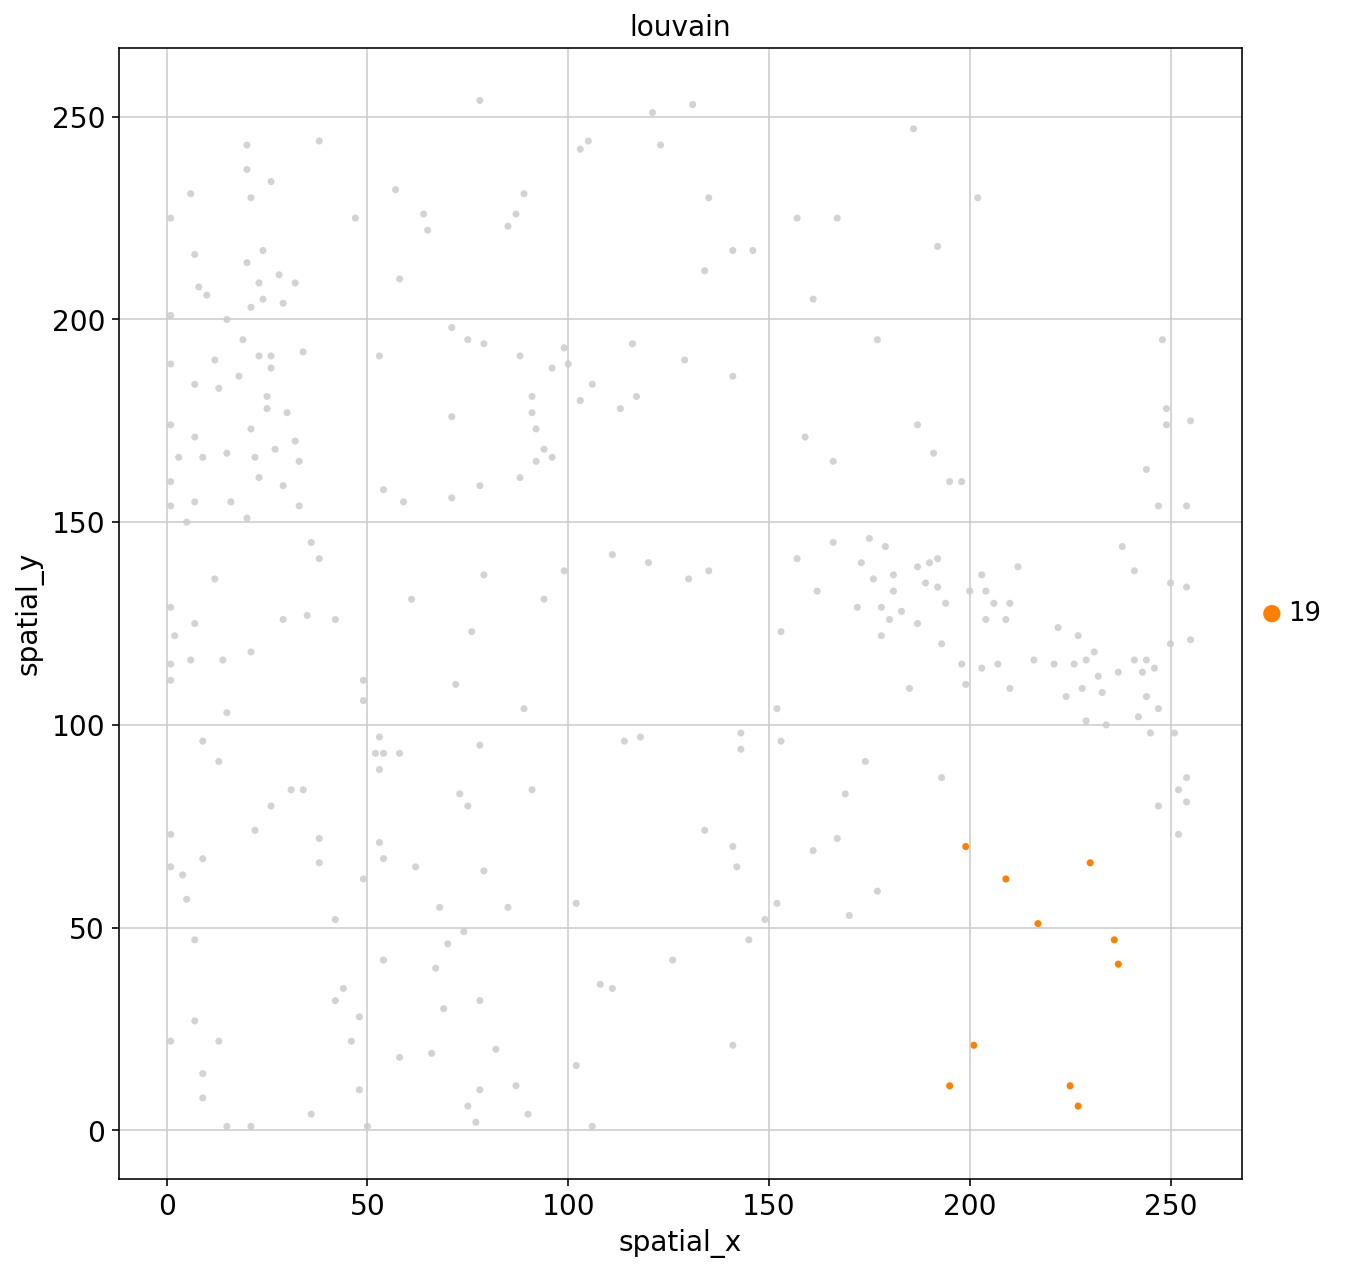

In [194]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.scatter(a_cls2,x='spatial_x',y='spatial_y',size=50,color='louvain',palette=cmp_5,ax=ax,groups='19')

... storing 'cls2' as categorical


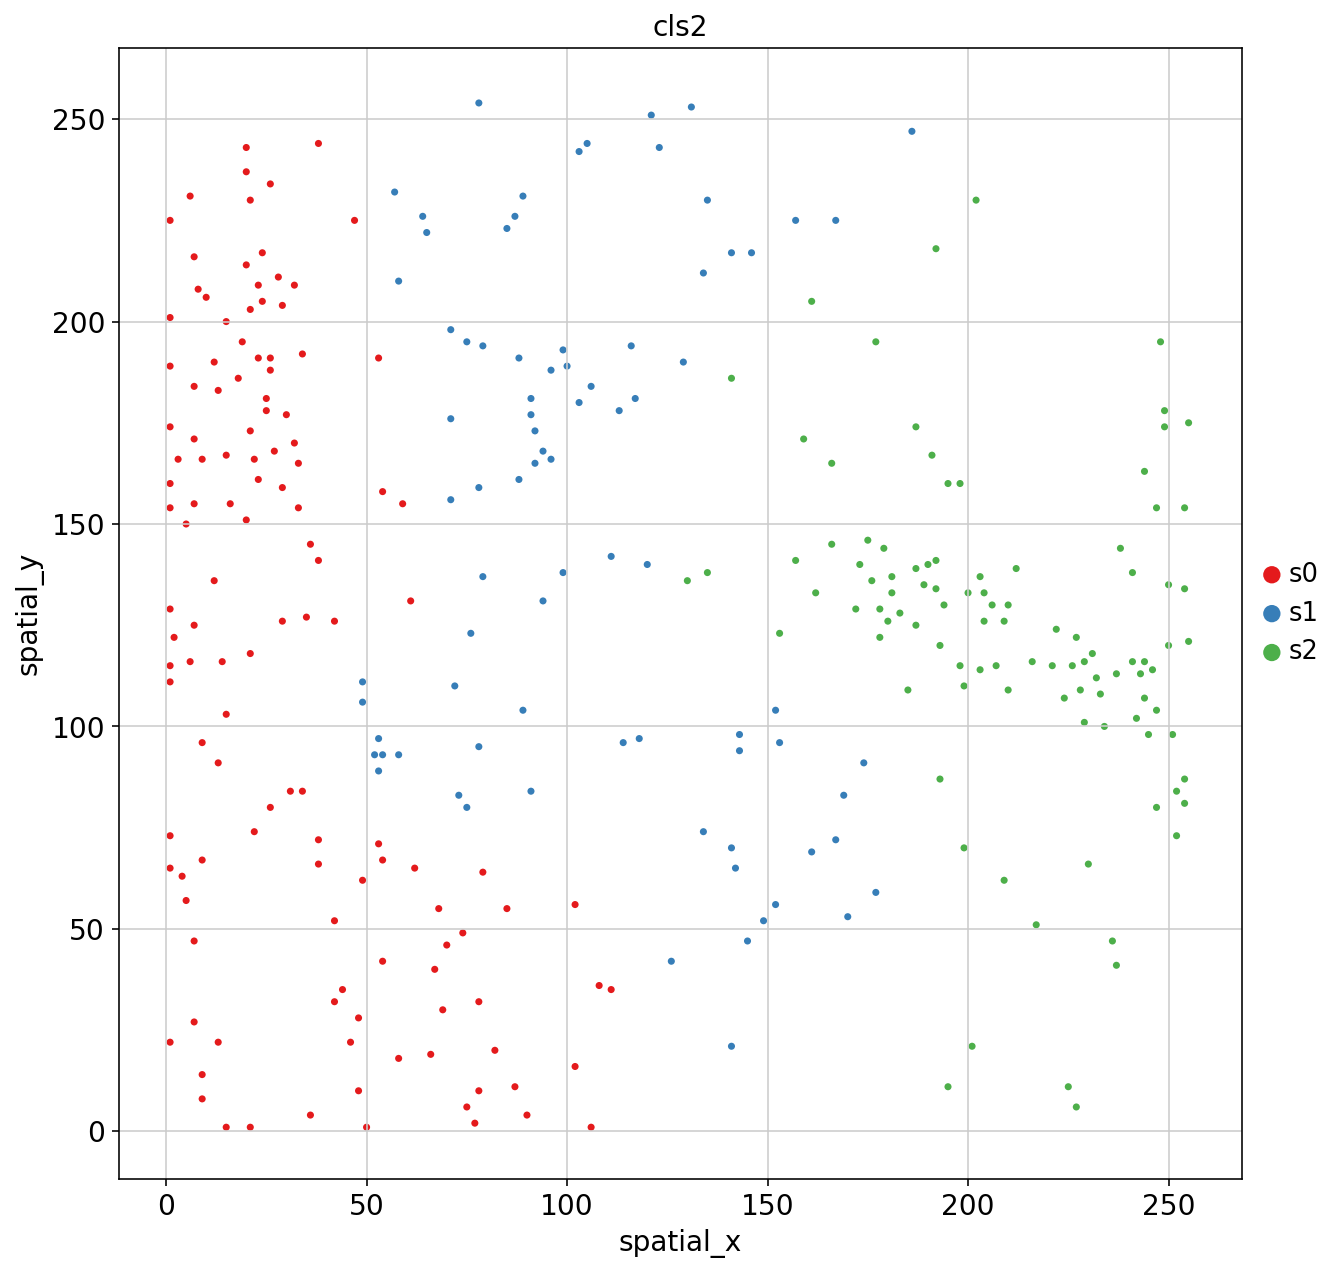

In [197]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.scatter(a_cls2,x='spatial_x',y='spatial_y',size=50,color='cls2',palette=cmp_5,ax=ax)

In [97]:
a_tmp = a.copy()

In [200]:
original_cls = np.array(a_tmp.obs['SIMS-Cluster'])
# a_tmp.obs['SIMS-Cluster']
original_cls[original_cls=='2'] = a_cls2.obs['cls2']
original_cls[original_cls=='s0'] = '1'
original_cls[original_cls=='s1'] = '5'
original_cls[original_cls=='s2'] = '2'



In [201]:
np.unique(original_cls)

array(['1', '2', '3', '4', '5'], dtype=object)

In [202]:
a.obs['cls_sub'] = original_cls

In [199]:
np.unique(a.obs['SIMS-Cluster'])

array(['1', '2', '3', '4'], dtype=object)

In [214]:
a.obs['cls_sub'] = cur_cls

In [216]:
# '1','2','5','3','4'
# a.obs.cls_sub.cat.reorder_categories(['1','2','5','3','4'], inplace=True) 
# cur_cls = np.array(a.obs['cls_sub'])
a.obs['cls_sub'][cur_cls=='3']='4'
a.obs['cls_sub'][cur_cls=='4']='5'
a.obs['cls_sub'][cur_cls=='5']='3'
# a.obs['cls_sub'][cur_cls=='4']='3'



# '1':
# '2':

/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [219]:
a.obs['cls_sub'] = np.array(a.obs['cls_sub']).astype('str')
a.obs['cls_sub'] = a.obs['cls_sub'].astype('category')

In [215]:
cmp_5 = palettable.colorbrewer.qualitative.Set1_5.mpl_colors
# 0:红
# 1:蓝
# 2:绿
# 3:紫
# 4:黄

array(['1', '2', '3', '4', '5'], dtype=object)

In [221]:
cur_cmp = [cmp_5[4],cmp_5[2],cmp_5[3],cmp_5[1],cmp_5[0]]

In [222]:
a.uns['cls_sub_colors'] = cur_cmp

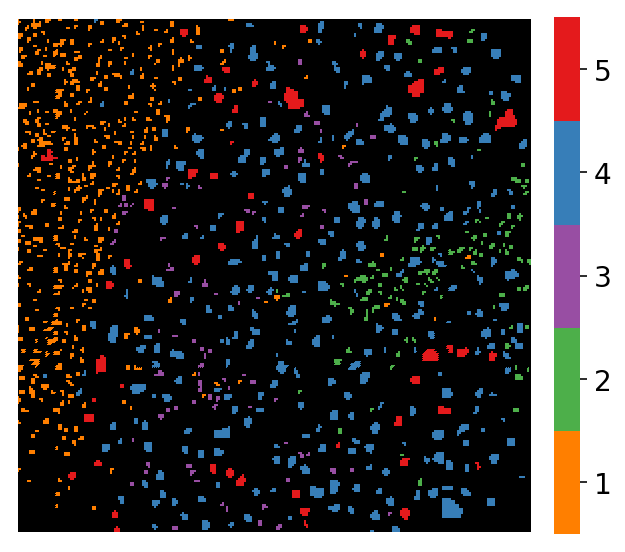

In [223]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[0,1,2,3,4])


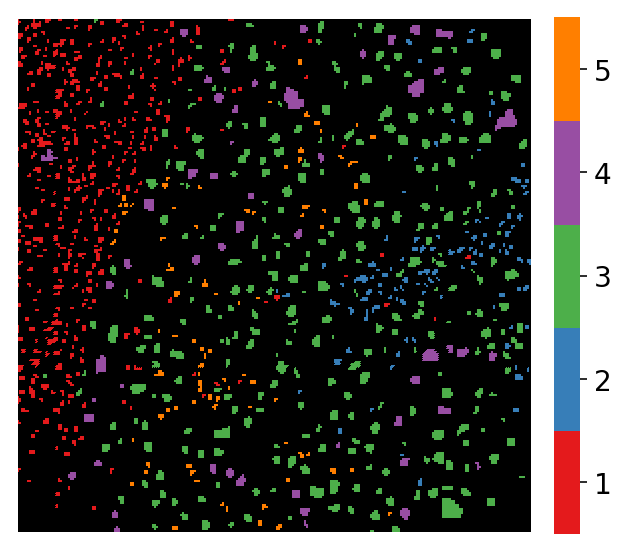

In [203]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[0,1,2,3,4])


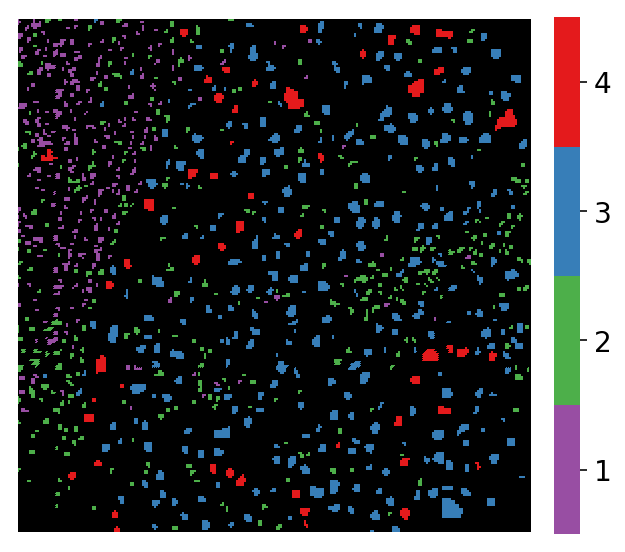

In [198]:
plot_label_image(a.obs['SIMS-Cluster'],a.uns['SIMS-Cluster_colors'],mask=[0,1,2,3,4])


In [112]:
a.uns['cls_sub_colors'] = cmp_5

... storing 'cls2' as categorical


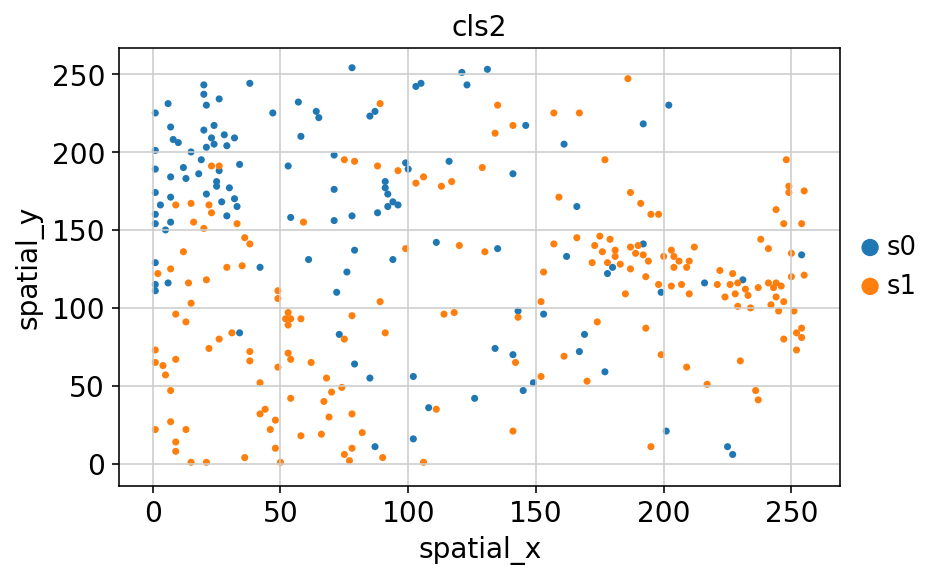

In [70]:
sc.pl.scatter(a_cls2,x='spatial_x',y='spatial_y',size=50,color='cls2')

In [26]:
import sklearn
cls2_sub = sklearn.cluster.KMeans(2).fit_predict(a_cls2.X)

AttributeError: module 'sklearn' has no attribute 'cluster'

In [20]:
a_cls2.obs['77.31'] = a_cls2

View of AnnData object with n_obs × n_vars = 311 × 228 
    obs: 'SIMS-Cluster', 'fibro_dist', 'fibro_zonation'
    uns: 'SIMS-Cluster_colors', 'dendrogram_SIMS-Cluster', 'fibro_zonation_colors', 'rank_genes_groups', 'rep_list'
    obsm: 'X_umap', 'X_pca', 'spatial'

... storing 'cls_sub' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have 

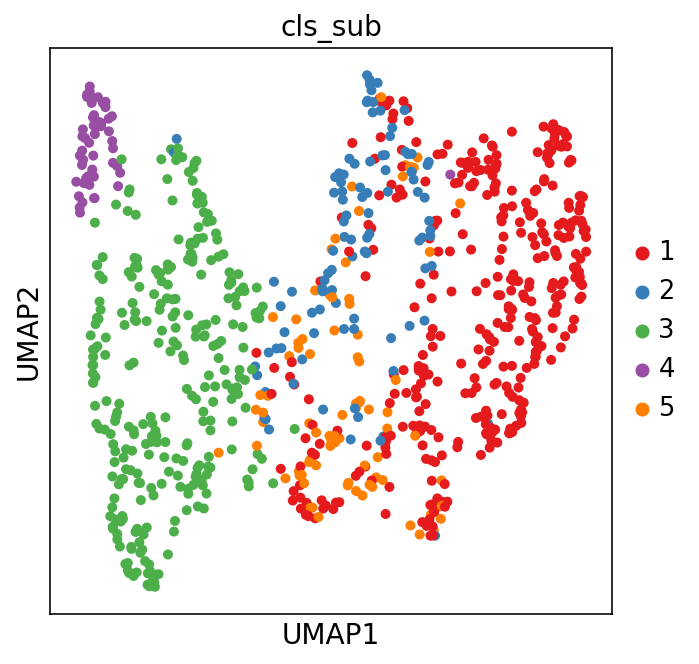

In [204]:
sc.settings.figdir = 'figures/Fig2/c4/'
save_umap = '_c4.pdf'
fig,ax = plt.subplots(1,1,figsize=(5,5))
# sc.pl.umap(a,color=['cls_4'],ax=ax,save=save_umap,s=100)
sc.pl.umap(a,color=['cls_sub'],ax=ax,save=None,s=100)


## visual cell typing

In [321]:
sc.pp.neighbors(a)
sc.tl.louvain(a)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

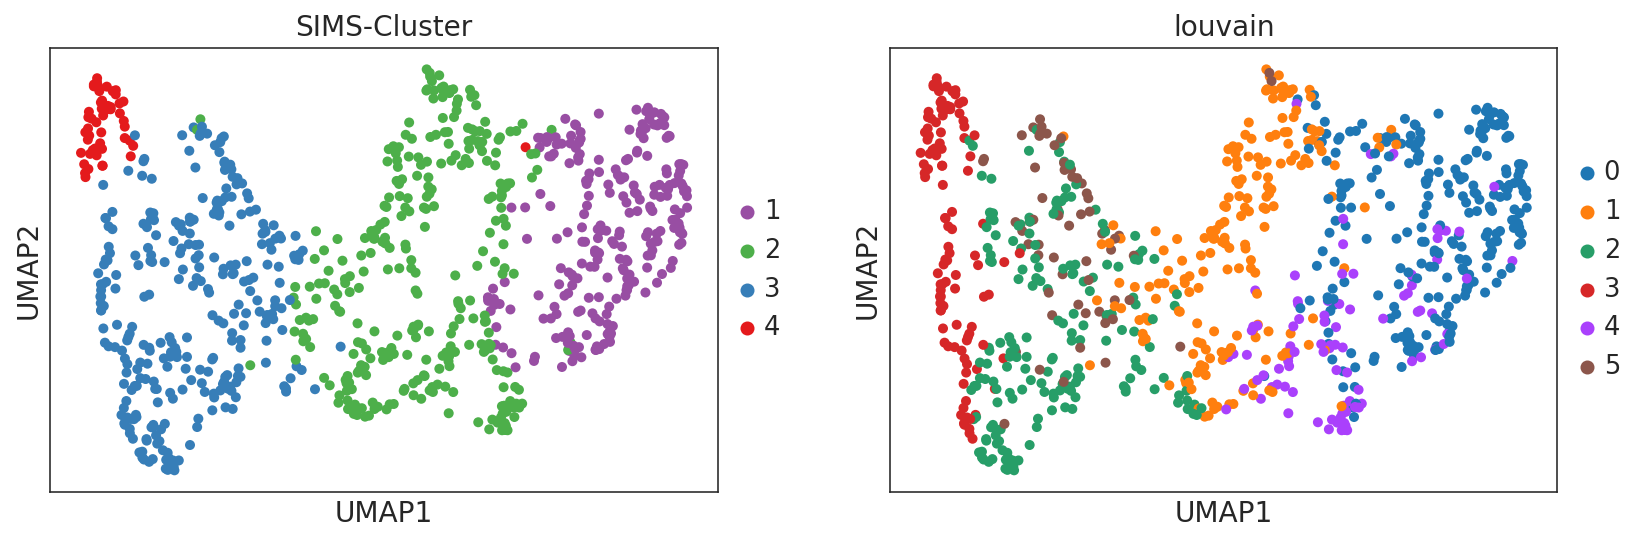

In [322]:
sc.pl.umap(a,color=['SIMS-Cluster','louvain'],save=None,s=100)

In [325]:
1+1

2

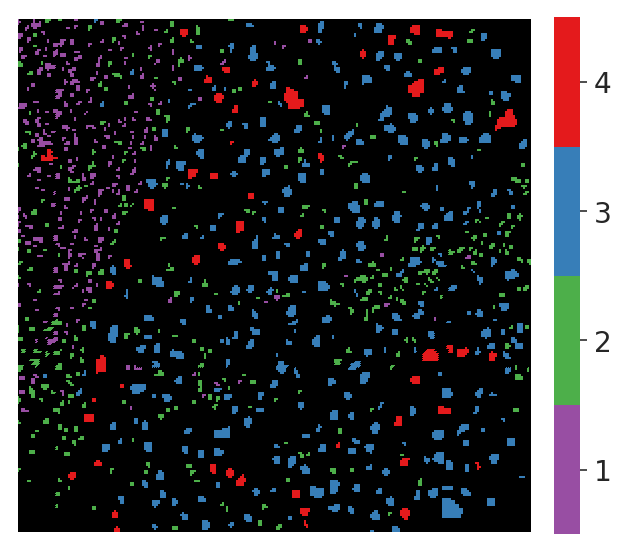

In [318]:
plot_label_image(a.obs['SIMS-Cluster'],a.uns['SIMS-Cluster_colors'],mask=[0,1,2,3,4],save=None)


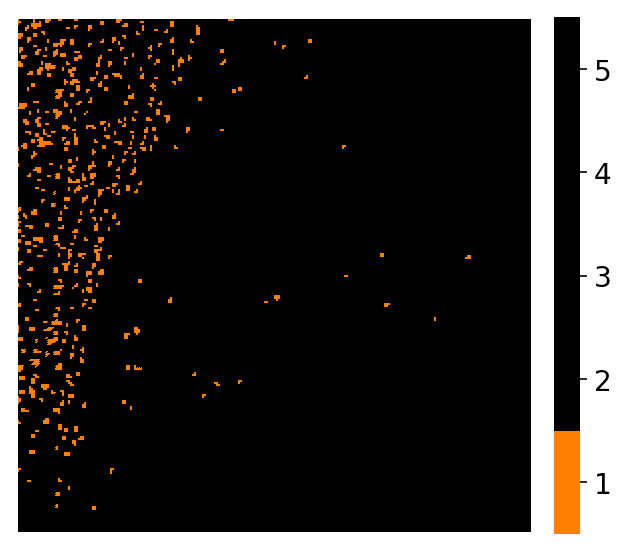

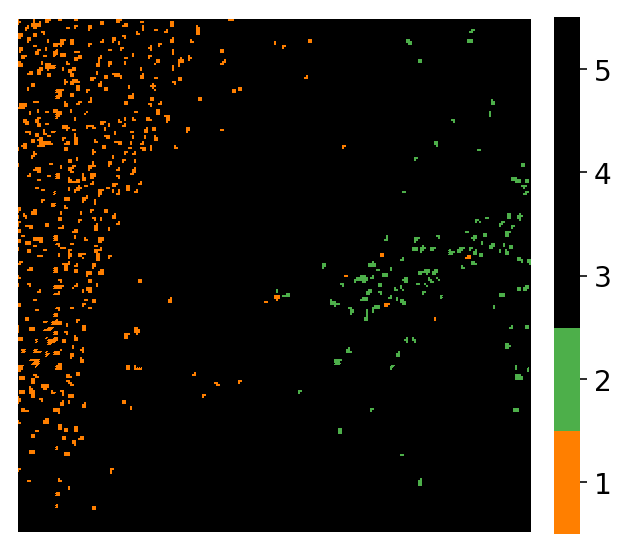

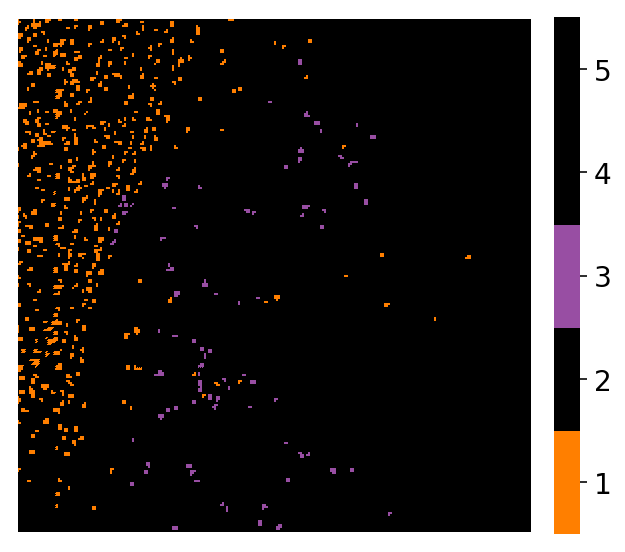

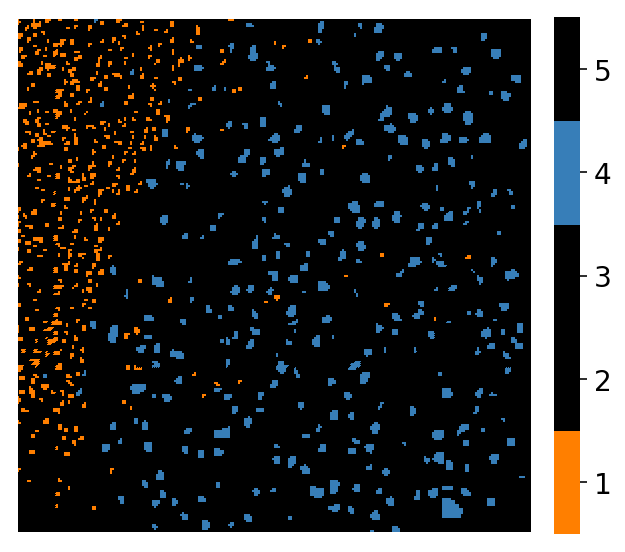

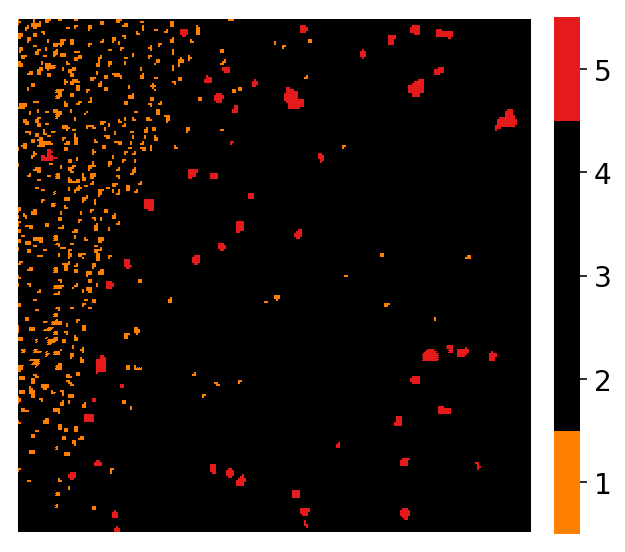

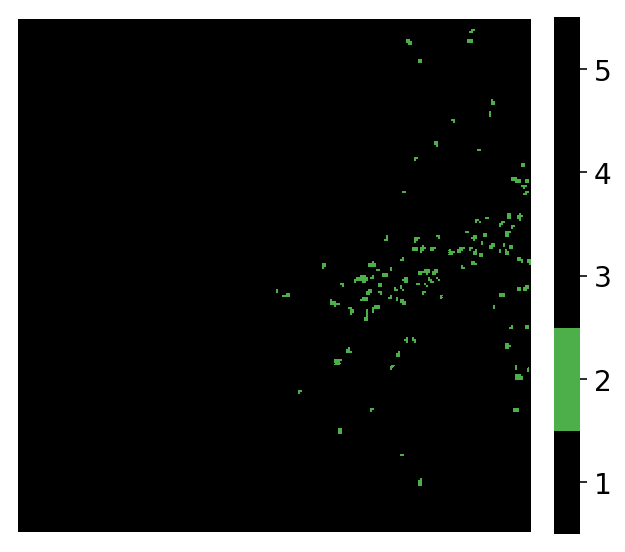

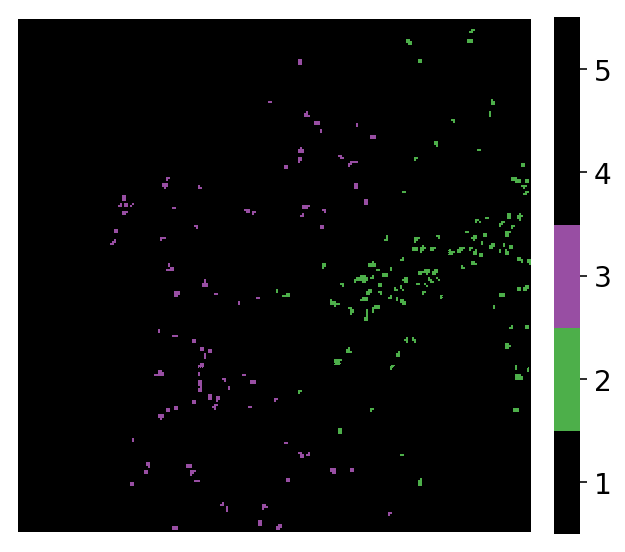

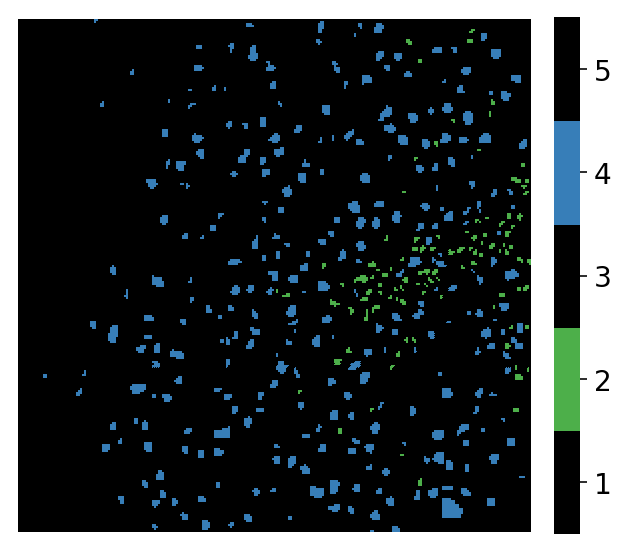

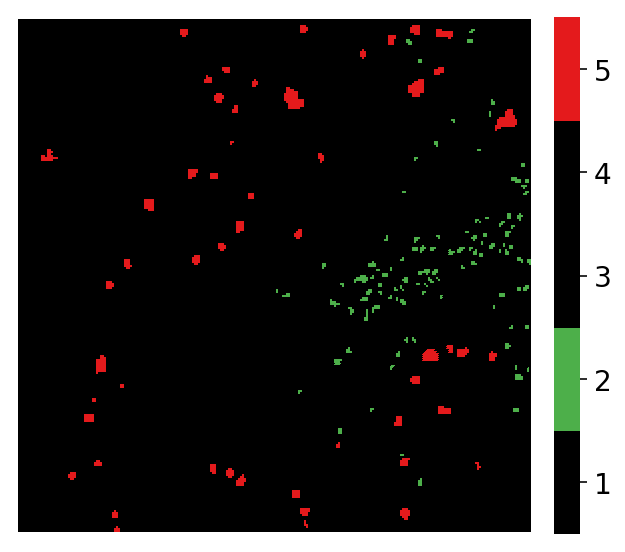

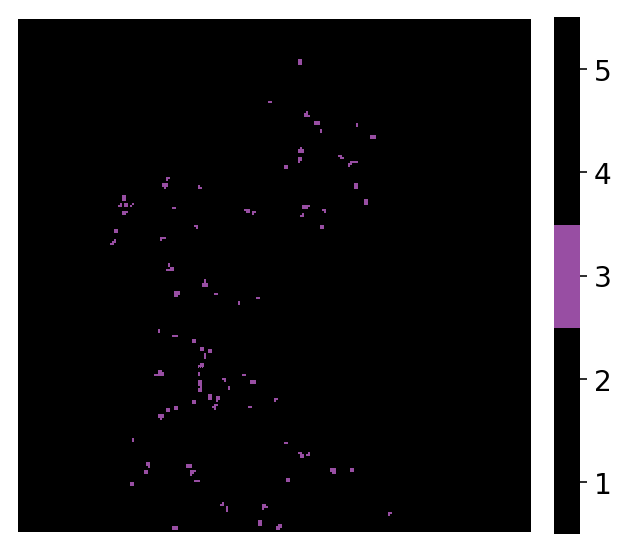

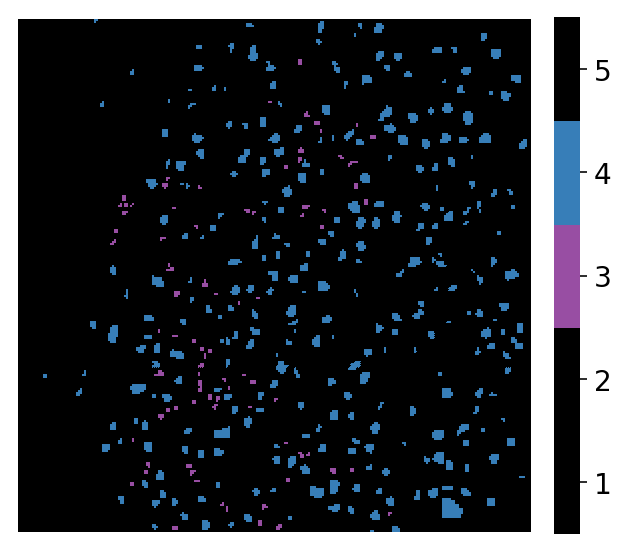

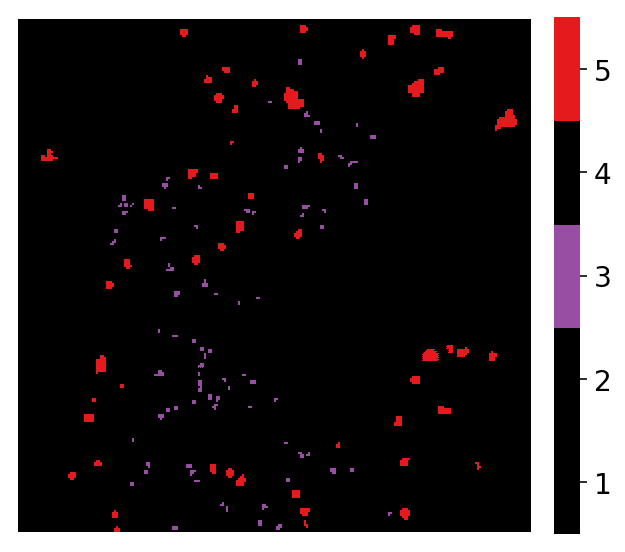

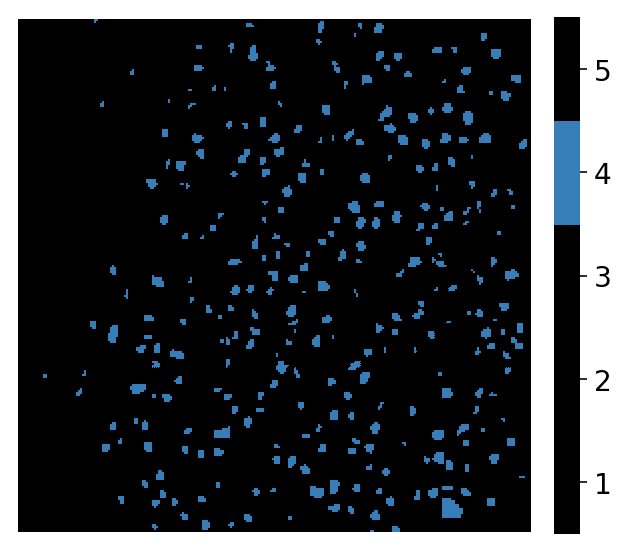

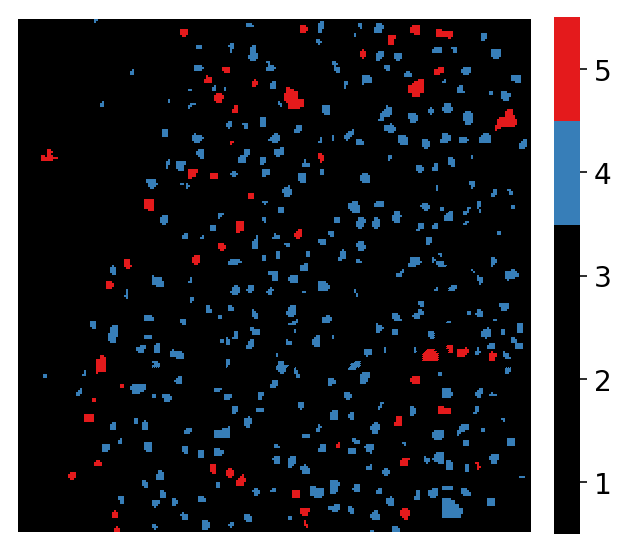

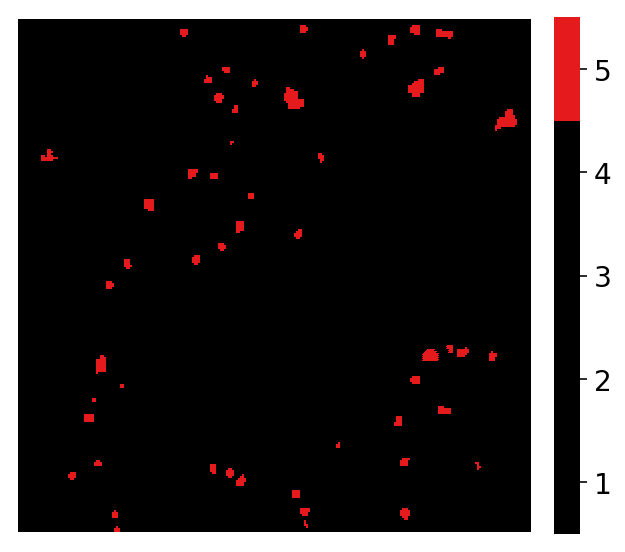

In [231]:
# 需要1～4；分别；4红其他白
save_cluster_image = '/home/yzy/ipynbs/figures/Fig4/c5/cluster_image/cluster_image_{0}_c5.pdf'

for i in range(5):
    for j in range(i,5):
        cur_save = save_cluster_image.format(str(i)+str(j))
        plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[i,j],save=cur_save)
    


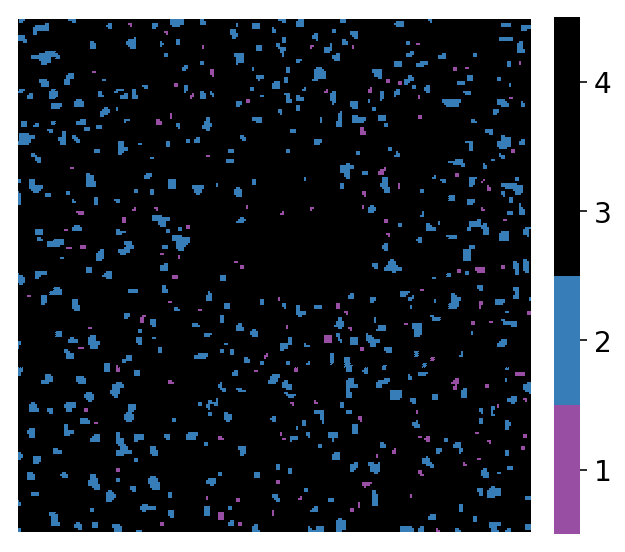

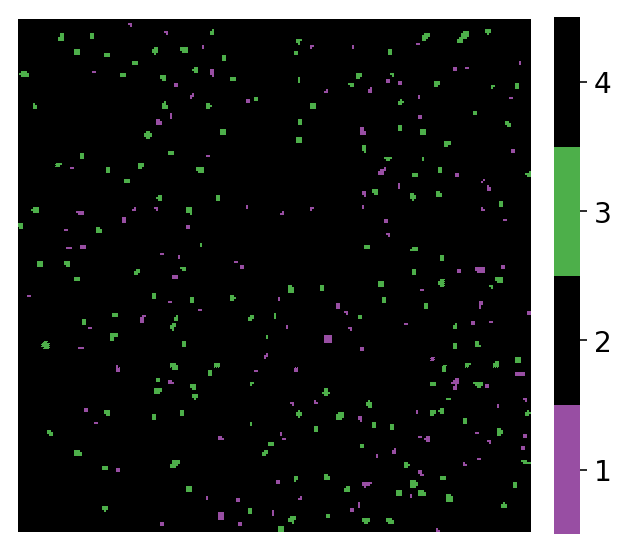

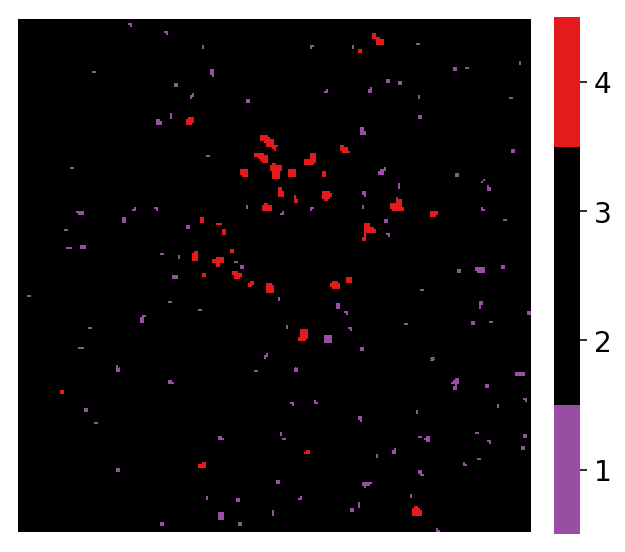

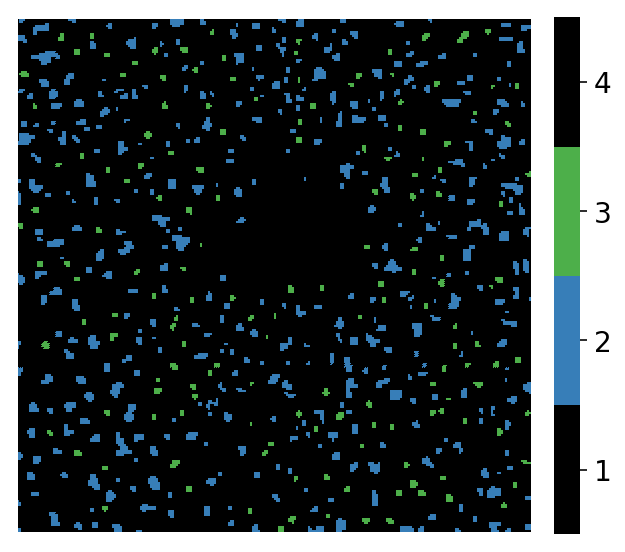

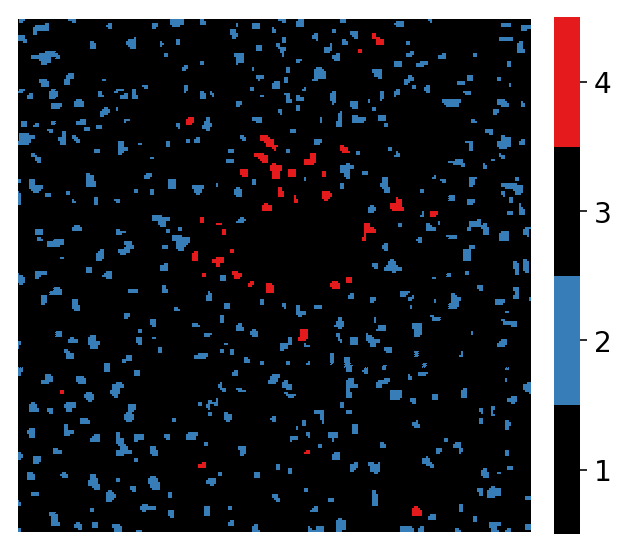

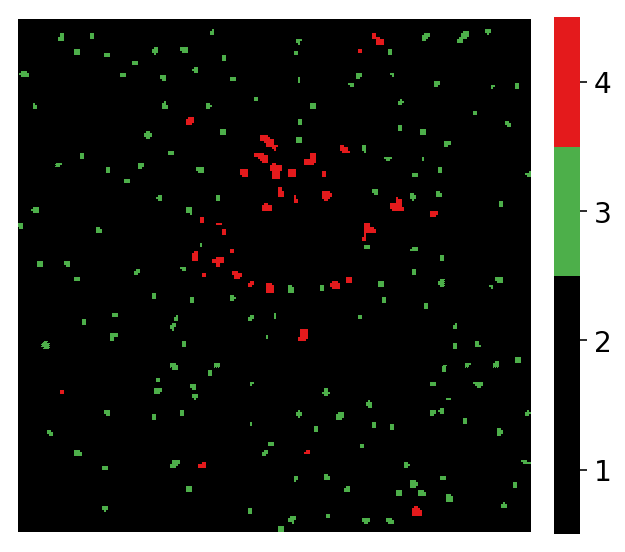

In [65]:
for i in range(4):
    for j in range(i+1,4):
        cur_save = save_cluster_image.format(str(i)+'-'+str(j))
        plot_label_image(a.obs['cls_4'],a.uns['cls_4_colors'],mask=[i,j],save=cur_save)
        
        

In [104]:
a

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'SIMS-Cluster', 'fibro_dist', 'fibro_zonation', 'cls_sub'
    uns: 'SIMS-Cluster_colors', 'dendrogram_SIMS-Cluster', 'fibro_zonation_colors', 'rank_genes_groups', 'rep_list', 'cls_sub_colors'
    obsm: 'X_umap', 'X_pca', 'spatial'

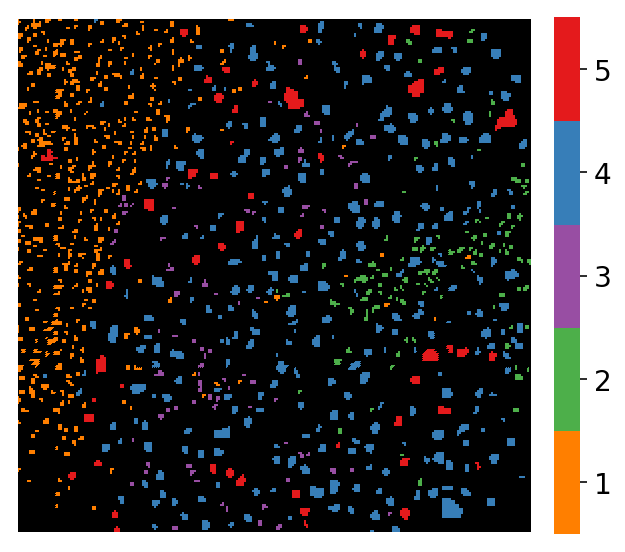

In [233]:
# 所有四色
# tmp_cmp = ['w']*3
# tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig4/c5/cluster_image/cluster_image_all.pdf'
# plot_label_image(a.obs['cls_4'],a.uns['cls_4_colors'],mask=[0,1,2,3],save=cur_save)
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[0,1,2,3,4],save=cur_save)


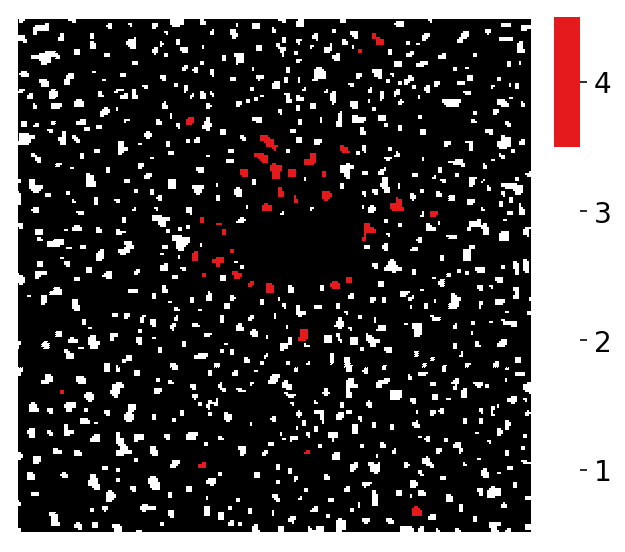

In [68]:
# 4红其他白
tmp_cmp = ['w']*3
tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig2/c4/cluster_image/cluster_image_nearfar.pdf'
plot_label_image(a.obs['cls_4'],tmp_cmp,mask=[0,1,2,3],save=cur_save)


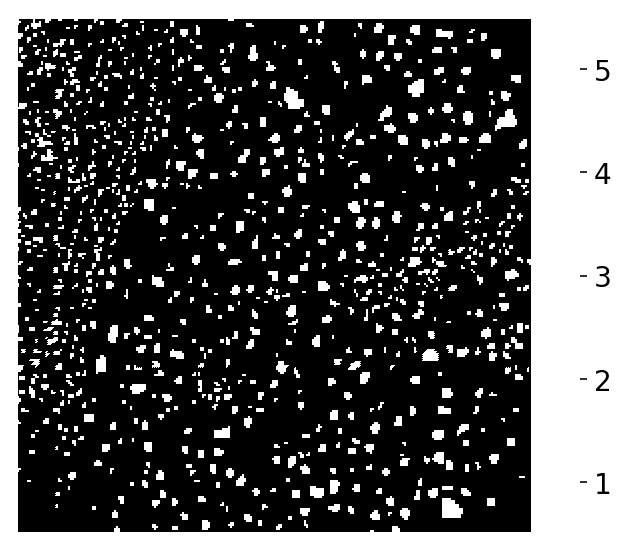

In [234]:
# 全白
tmp_cmp = ['w']*5
# tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig4/c5/cluster_image/cluster_image_cut.pdf'
plot_label_image(a.obs['cls_sub'],tmp_cmp,mask=[0,1,2,3,4],save=cur_save)


## differential expression heatmap

In [235]:
sc.tl.rank_genes_groups(a,groupby='cls_sub',method='t-test')

ranking genes
    finished (0:00:00)


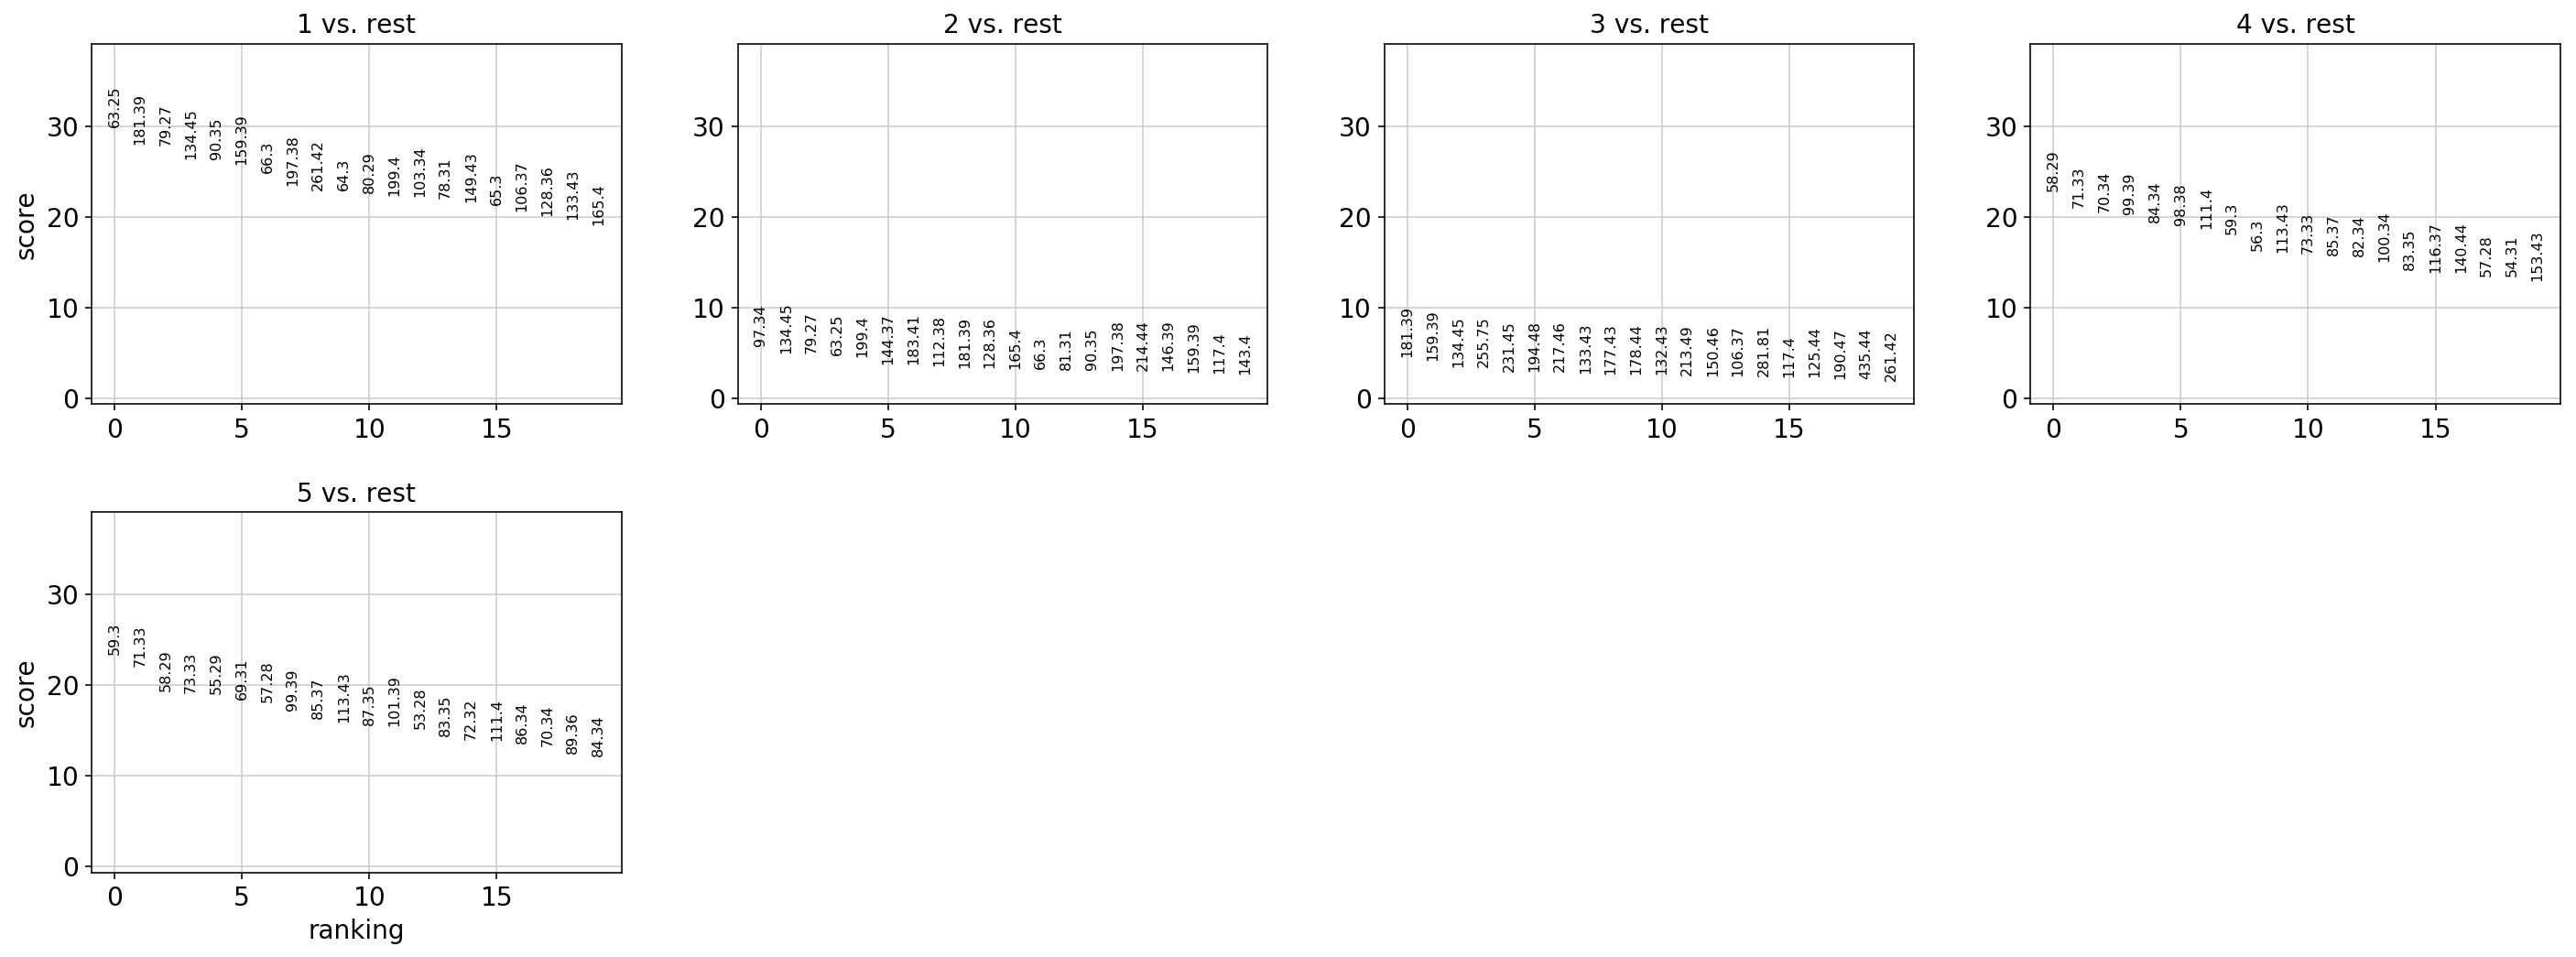

In [236]:
sc.pl.rank_genes_groups(a)

In [273]:
# 3 vs 1:91.36,75.32,66.32,65.31
# 1 vs 3:60.26,77.31,137.43,76.29

marker_list =[
#     Fib
    107.35,91.33,63.25,
    #     IC
#     181.42,144.41,128.39,91.36,
    181.39,97.34,79.27,112.38,
    #     EC:
#     60.26,77.31,137.43,
    77.31,76.31,
    
    
#     Hepa
    255.75,279.79,281.81,
    #     Hepa87+
#     221.56,87.36,101.41,59.31,71.34,
#     58.30,69.32,59.31,71.34,101.41,87.36
    55.29,57.28,69.31

]
marker_list = np.array(marker_list).astype('str')

In [263]:
a_tmp = a.copy()

In [269]:
EC_matter = ['77.31','76.31','60.28']
a_tmp[a_tmp.obs['cls_sub']=='3',EC_matter].X = a_tmp[a_tmp.obs['cls_sub']=='3',EC_matter].X*1.05

In [267]:
FA_matter = ['255.75','279.79','281.81']
a_tmp[a_tmp.obs['cls_sub']=='3',FA_matter].X = a_tmp[a_tmp.obs['cls_sub']=='3',FA_matter].X/1.2

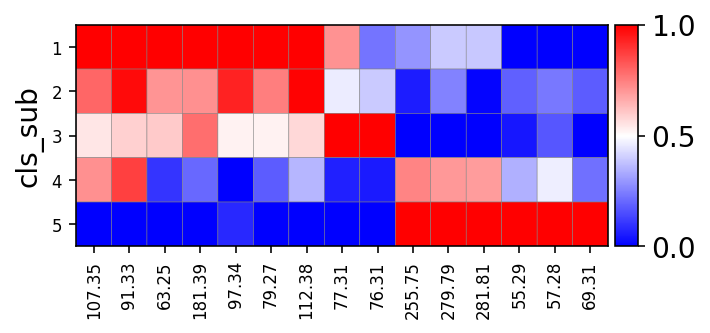

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[4.8, 0, 0.2])

In [276]:
sc.settings.figdir = 'figures/Fig4/c5/diff/'
save_heatmap = '_c5.pdf'
sc.pl.matrixplot(a_tmp,marker_list,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=save_heatmap)


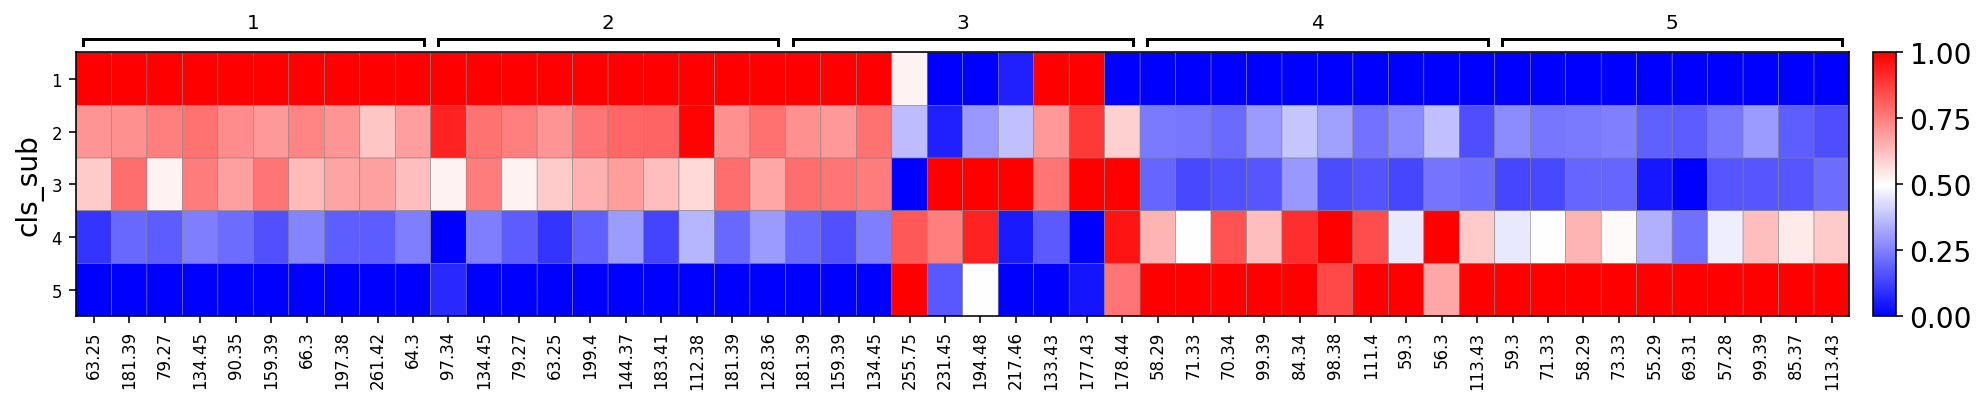

In [244]:
sc.pl.rank_genes_groups_matrixplot(a_tmp,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


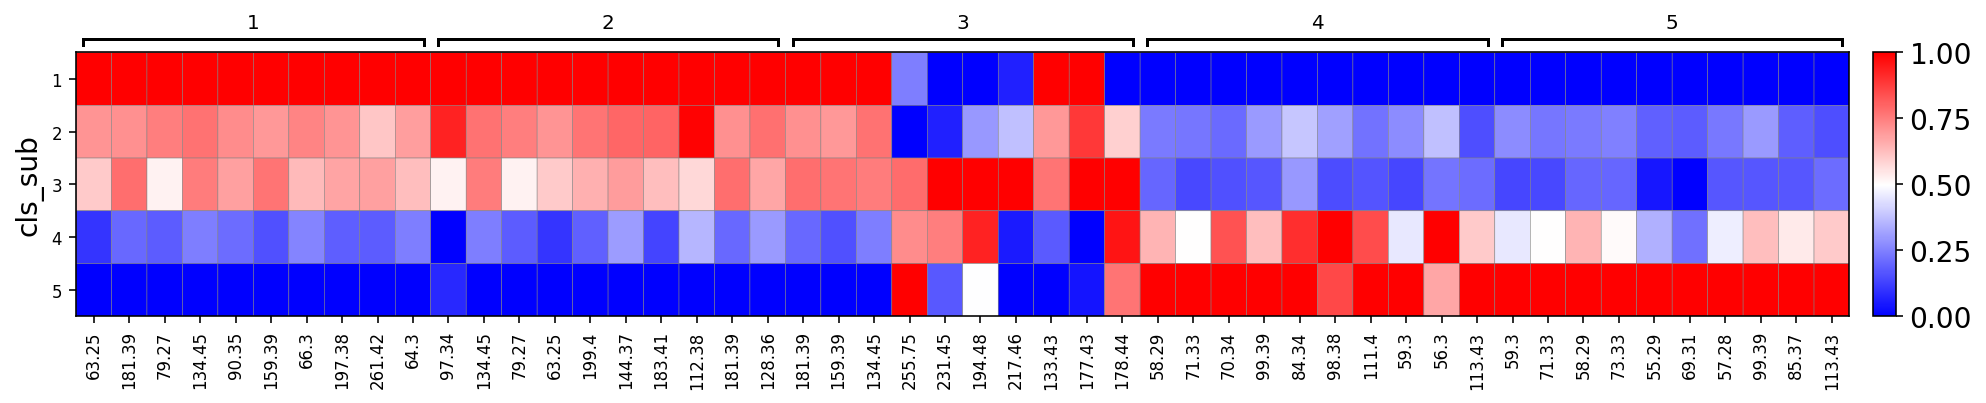

In [239]:
sc.pl.rank_genes_groups_matrixplot(a,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


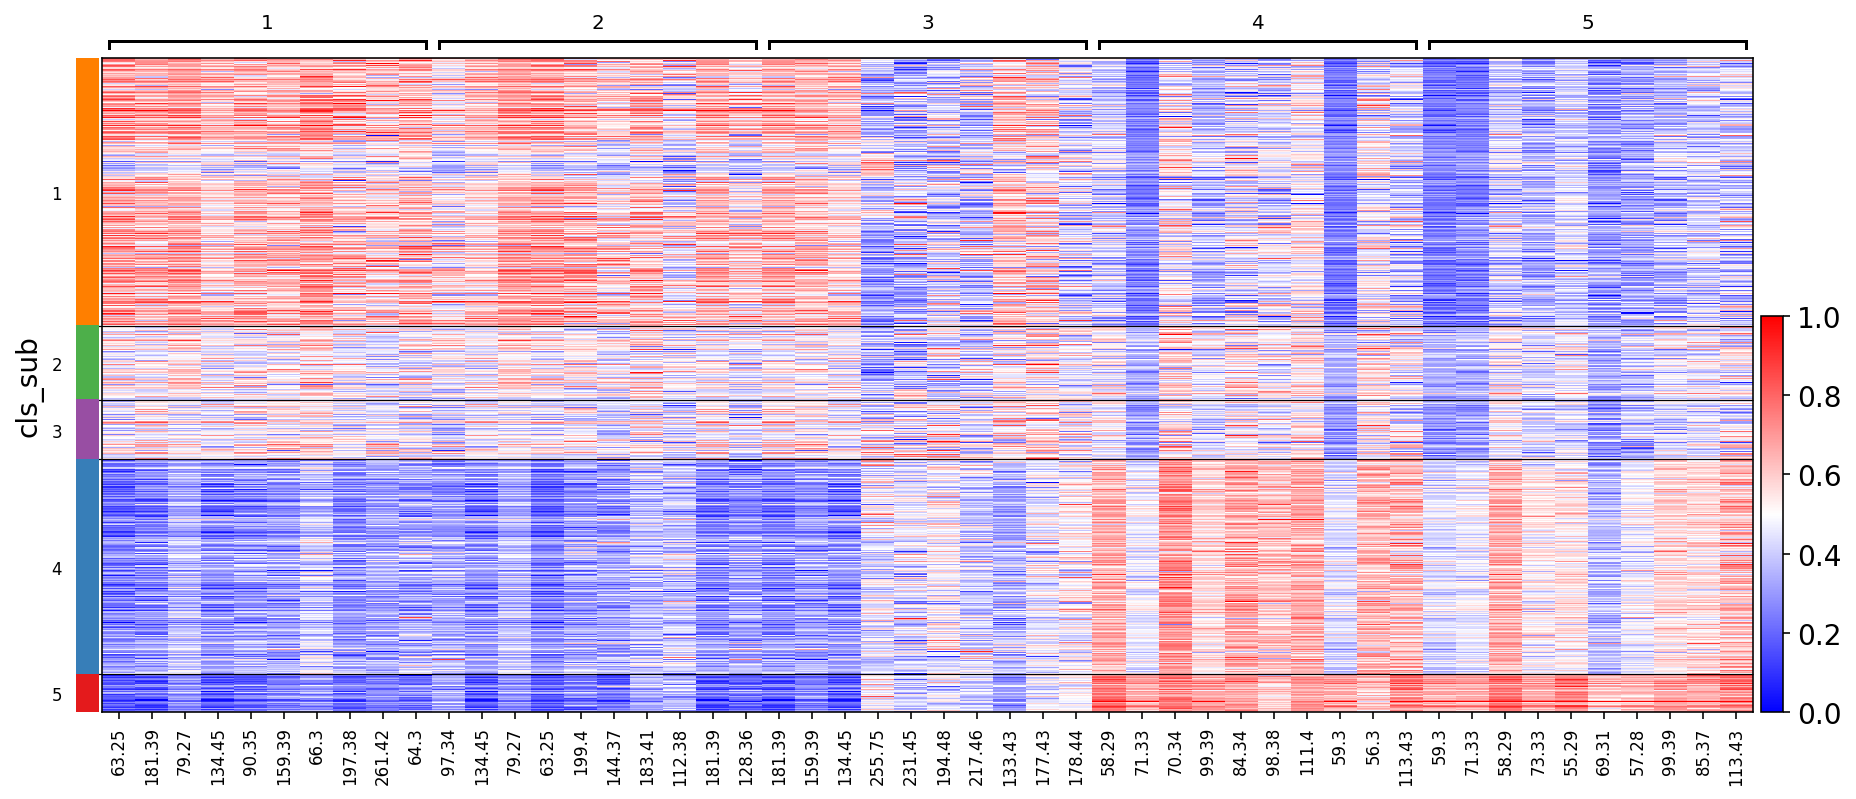

In [238]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [1]:
1+1

2

In [154]:
# 3 vs 1:91.36,75.32,66.32,65.31
# 1 vs 3:60.26,77.31,137.43,76.29

marker_list =[
    #     IC
    181.42,144.41,128.39,91.36,
    #     EC:
    60.26,77.31,137.43,

#     Hepa
    253.79,255.83,281.87,
    #     Hepa87+
#     221.56,87.36,101.41,59.31,71.34,
    58.30,69.32,59.31,71.34,101.41,87.36


]
marker_list = np.array(marker_list).astype('str')

Index(['50.27', '50.83', '51.29', '52.29', '53.29', '54.32', '55.3', '56.31',
       '57.29', '58.3',
       ...
       '409.57', '419.54', '425.58', '439.56', '441.52', '443.57', '447.59',
       '457.52', '466.02', '487.6'],
      dtype='object', name='index', length=244)

In [103]:
a_tmp = a.copy()

In [149]:
# a_tmp.obs.cls_4.cat.reorder_categories(['3','1','2','4'], inplace=True) 
a_tmp.uns['cls_4_colors'] = [cur_cmp[2],cur_cmp[0],cur_cmp[1],cur_cmp[3]]

In [105]:
a_tmp.obs.cls_4.cat.categories
['3','1','2','4']

Index(['1', '2', '3', '4'], dtype='object')

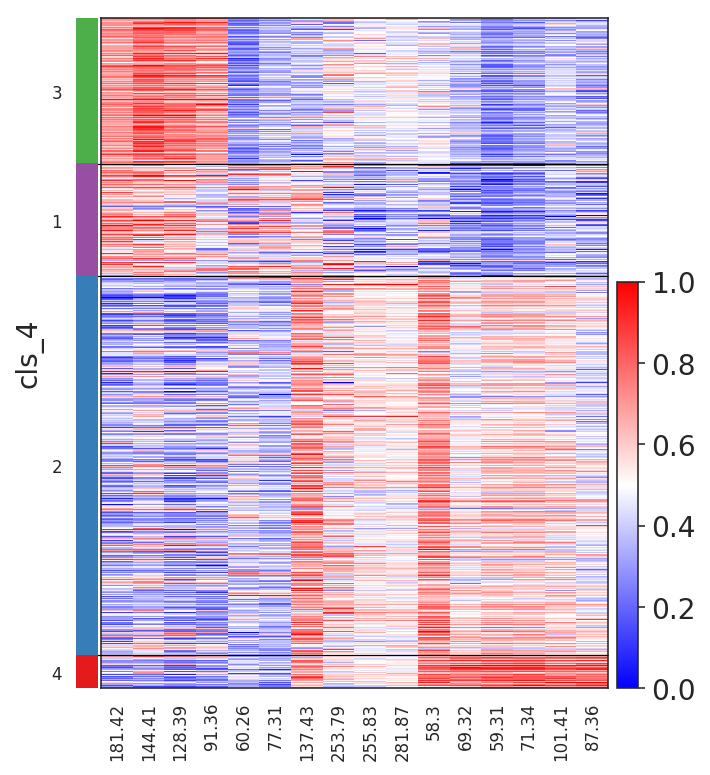

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 4.8, 0, 0.2])

In [155]:
sc.settings.figdir = 'figures/Fig2/c4/diff/'
save_heatmap = '_c4.pdf'
sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=save_heatmap)
# sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


## Hepa Fib dist

In [278]:
a.obs['fibro_dist_mum'] = a.obs['fibro_dist']*400/256

In [280]:
np.unique(a.obs['cls_sub'])

array(['1', '2', '3', '4', '5'], dtype=object)

In [291]:
a_hep_normal[a_hep_normal.obs['fibro_dist_mum']<50]

View of AnnData object with n_obs × n_vars = 31 × 228 
    obs: 'SIMS-Cluster', 'fibro_dist', 'fibro_zonation', 'cls_sub', 'fibro_dist_mum'
    uns: 'SIMS-Cluster_colors', 'dendrogram_SIMS-Cluster', 'fibro_zonation_colors', 'rank_genes_groups', 'rep_list', 'cls_sub_colors', 'dendrogram_cls_sub'
    obsm: 'X_umap', 'X_pca', 'spatial'

In [292]:
import scipy

In [304]:
c_hep_normal='4'
c_hep_87='5'

a_hep_normal = a[a.obs['cls_sub']==c_hep_normal]
a_hep_87 = a[a.obs['cls_sub']==c_hep_87]
a_hep_all = a[a.obs['cls_sub'].isin([c_hep_87,c_hep_normal])]
thre_list = []
count_normal_list = []
count_normal_standard_list = []
count_87_list = []
count_87_standard_list = []
count_ratio_list = []
count_ratio_standard_list =[]
dist_pvalue_list = []
dist_pvalue_list2 = []

thre_range = range(40,500)
for i in thre_range:
    print(i)
    cur_a_all = a_hep_all[a_hep_all.obs['fibro_dist_mum']<i]
    cur_a_87 = a_hep_87[a_hep_87.obs['fibro_dist_mum']<i]
    cur_a_normal = a_hep_normal[a_hep_normal.obs['fibro_dist_mum']<i]
    
    cur_dist_87 = cur_a_87.obs['fibro_dist_mum']
    cur_dist_all = cur_a_all.obs['fibro_dist_mum']
    cur_dist_normal = cur_a_normal.obs['fibro_dist_mum']
    _,pvalue = scipy.stats.ranksums(cur_dist_87,cur_dist_all)
    _,pvalue2 = scipy.stats.ranksums(cur_dist_87,cur_dist_normal)
    
    dist_pvalue_list.append(pvalue)
    dist_pvalue_list2.append(pvalue2)
    
    count_normal = np.sum(a_hep_normal.obs['fibro_dist_mum']<i)
    count_normal_standard = count_normal/a_hep_normal.shape[0]
    count_87 = np.sum(a_hep_87.obs['fibro_dist_mum']<i)
    count_87_standard = count_87/a_hep_87.shape[0]
    
    thre_list.append(i)
    count_normal_list.append(count_normal)
    count_87_list.append(count_87)
    count_ratio_list.append(count_87/count_normal)
    
    count_normal_standard_list.append(count_normal_standard)
    count_87_standard_list.append(count_87_standard)
    count_ratio_standard_list.append(count_87_standard/count_normal_standard)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304


In [289]:
count_ratio_standard_list = np.range(count_ratio_standard_list)


53

In [298]:
cur_dist_all.shape

(349,)

In [305]:
scipy.stats.ranksums(cur_dist_87,cur_dist_normal)

RanksumsResult(statistic=-2.7319627745878616, pvalue=0.006295825397926693)

In [299]:
scipy.stats.ranksums(cur_dist_87,cur_dist_all)

RanksumsResult(statistic=-2.344711527278026, pvalue=0.019041805897712642)

In [300]:
scipy.stats.ttest_ind(cur_dist_87,cur_dist_all)

Ttest_indResult(statistic=-2.3010366641106335, pvalue=0.021903063000418107)

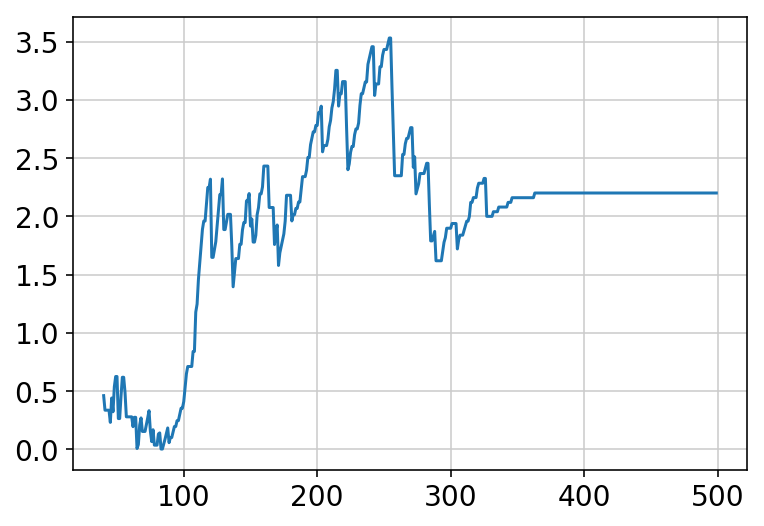

In [309]:
plt.plot(thre_list,-np.log10(dist_pvalue_list2))

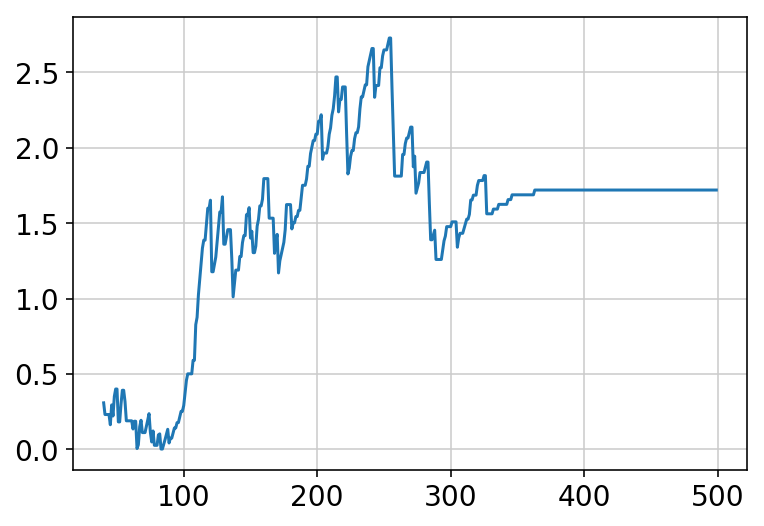

In [310]:
plt.plot(thre_list,-np.log10(dist_pvalue_list))

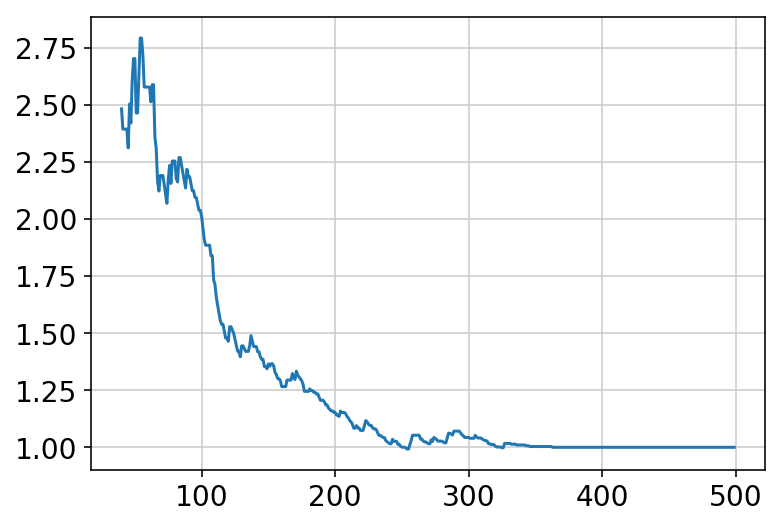

In [290]:
plt.plot(thre_list,count_ratio_standard_list)

In [312]:
import matplotlib
matplotlib.__version__

'3.0.3'

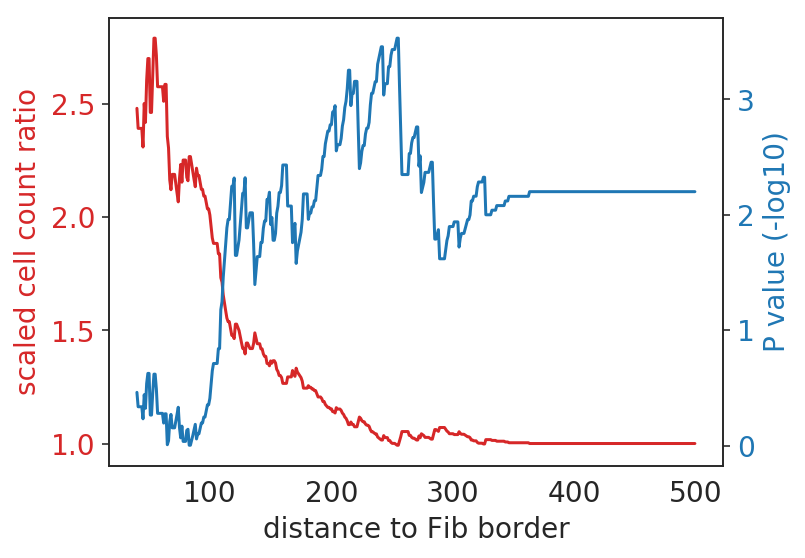

In [315]:
sns.set_style('white')
t=thre_list
data1 = count_ratio_standard_list
data2 = -np.log10(dist_pvalue_list2)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('distance to Fib border')
ax1.set_ylabel('scaled cell count ratio', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('P value (-log10)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Leu discover

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

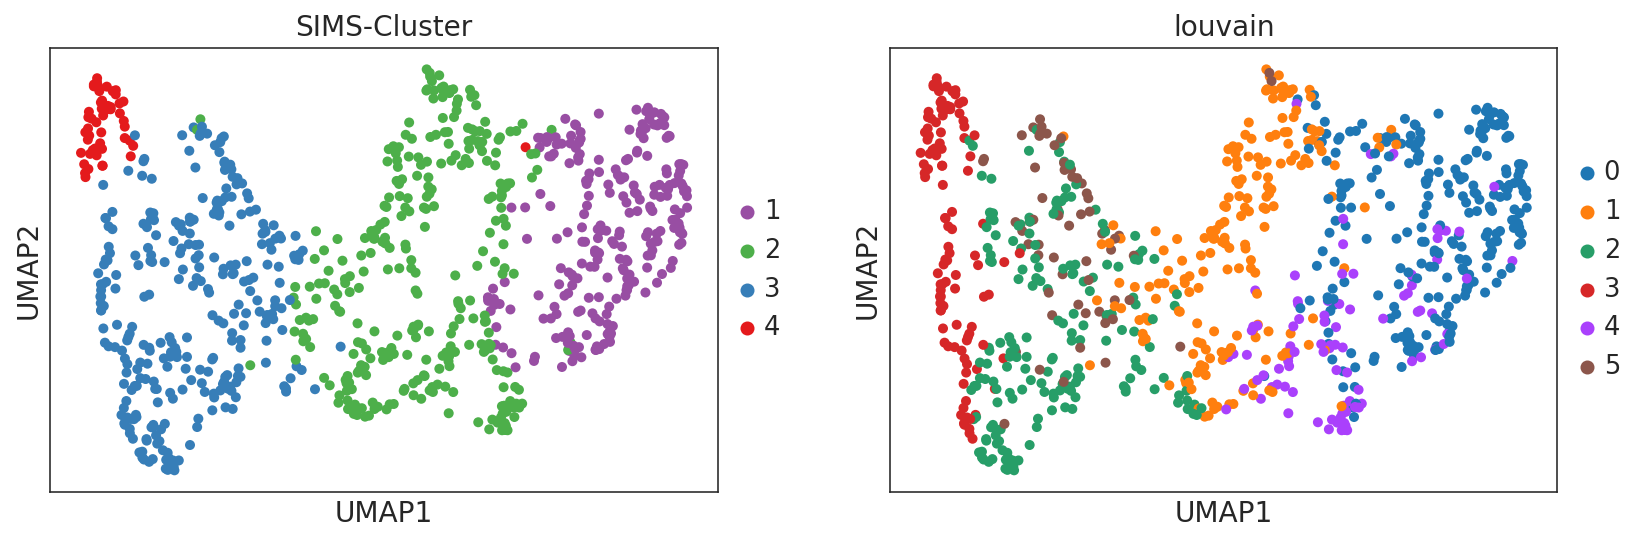

In [326]:
sc.pl.umap(a,color=['SIMS-Cluster','louvain'],save=None,s=100)

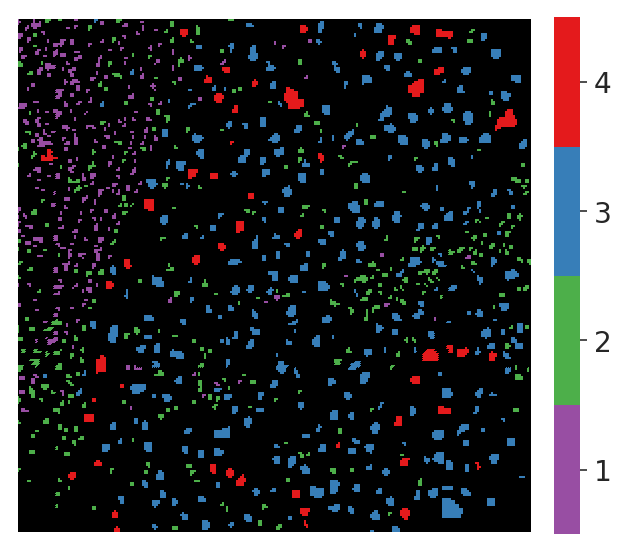

In [327]:
plot_label_image(a.obs['SIMS-Cluster'],a.uns['SIMS-Cluster_colors'],mask=[0,1,2,3,4],save=None)


In [328]:
a_ec = a[a.obs['SIMS-Cluster']=='2']

In [331]:
sc.pp.neighbors(a_ec)
sc.tl.louvain(a_ec)
sc.tl.leiden(a_ec)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


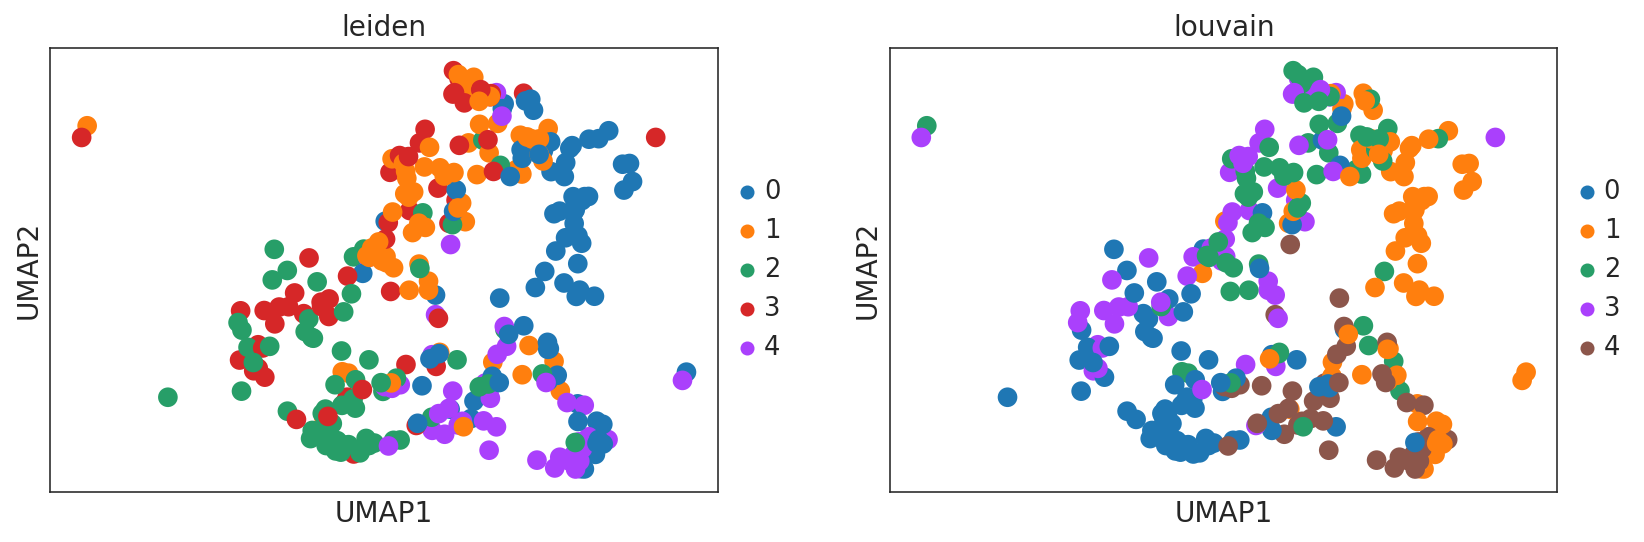

In [332]:
sc.pl.umap(a_ec,color=['leiden','louvain'])

In [333]:
sc.tl.rank_genes_groups(a_ec,groupby='louvain')

ranking genes
    finished (0:00:00)


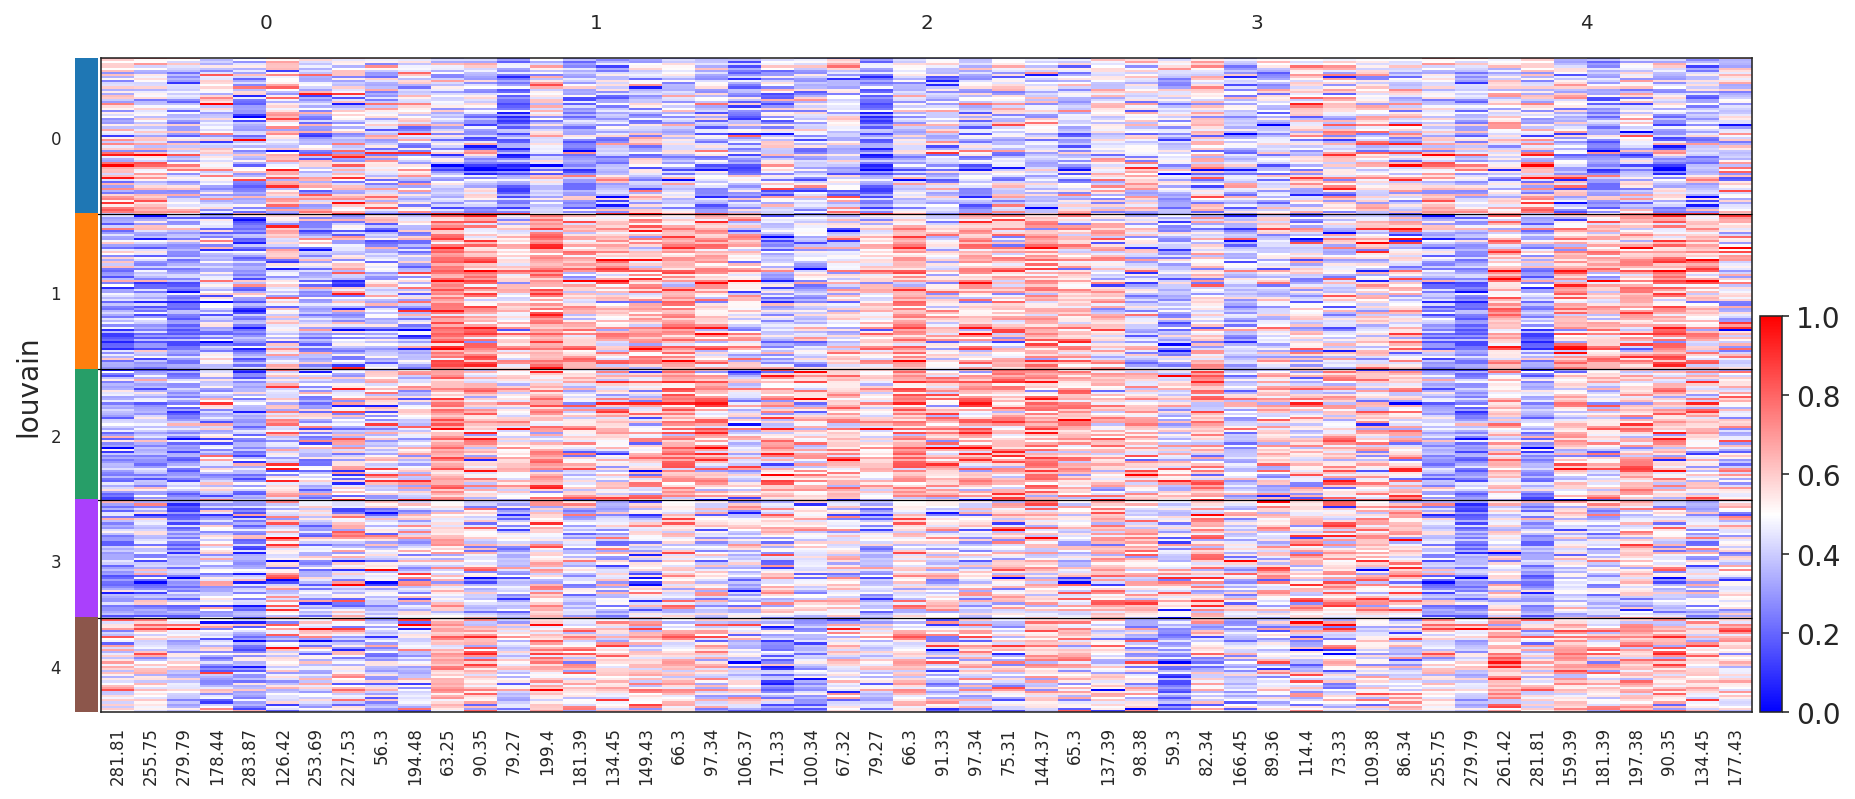

In [334]:
sc.pl.rank_genes_groups_heatmap(a_ec,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [337]:
a_cls_sub = np.array(a.obs['SIMS-Cluster'])
ec_cls = np.array(a_ec.obs['louvain'])
to_replace_cls = '2'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

In [338]:
a.obs['cls_sub_leu'] = a_cls_sub_modified
a.obs['cls_sub_leu'] = a.obs['cls_sub_leu'].astype('category')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

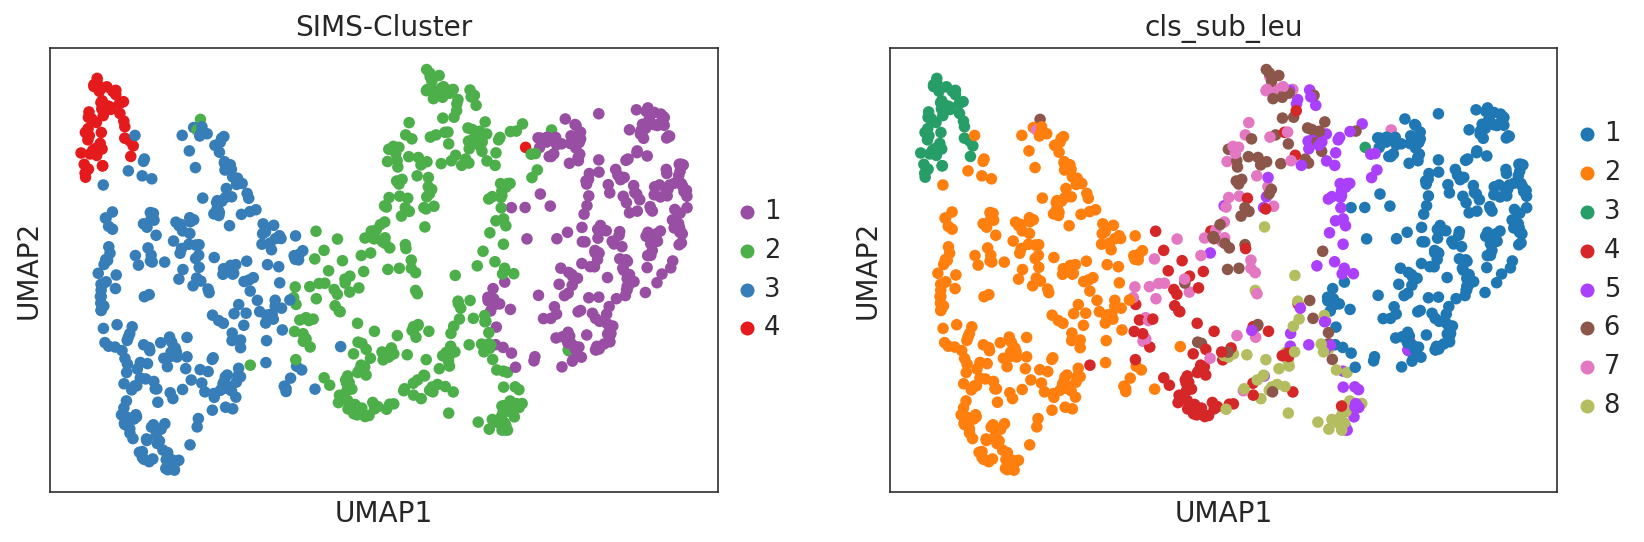

In [339]:
sc.pl.umap(a,color=['SIMS-Cluster','cls_sub_leu'])

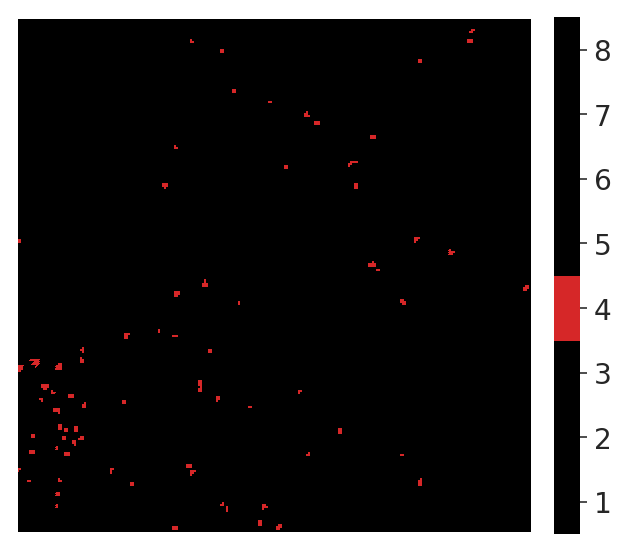

In [340]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[3],save=None)


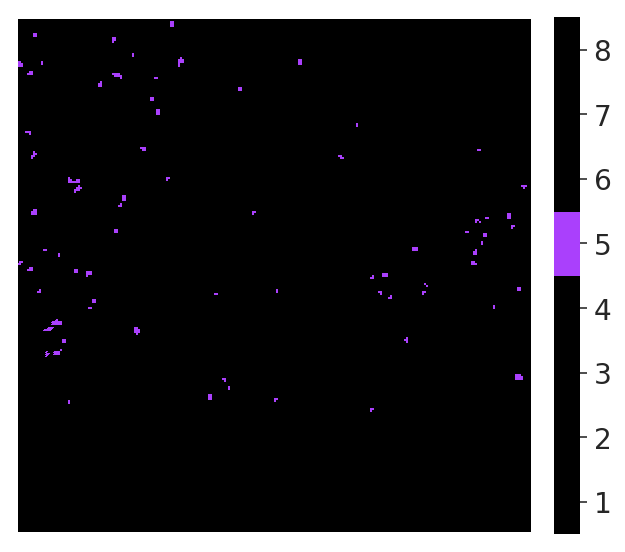

In [341]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[4],save=None)


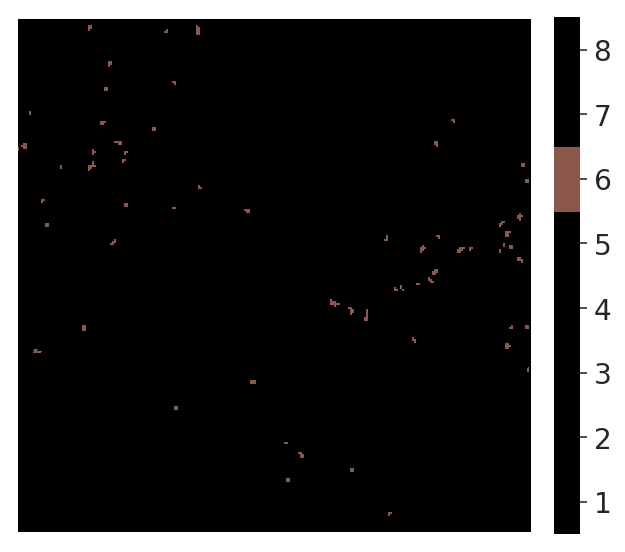

In [342]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[5],save=None)


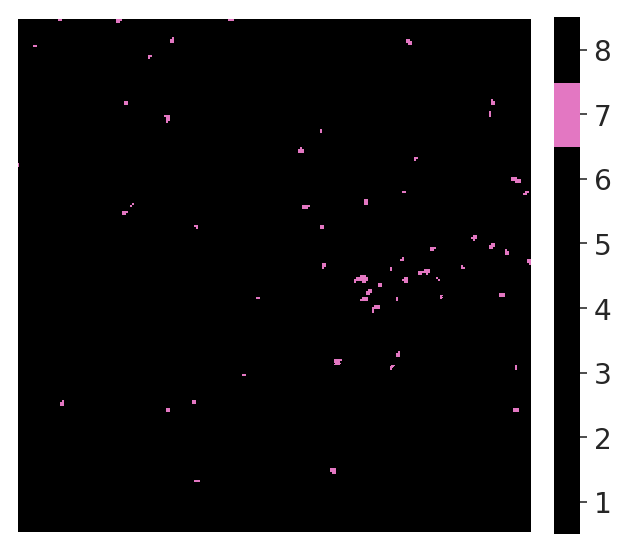

In [343]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[6],save=None)


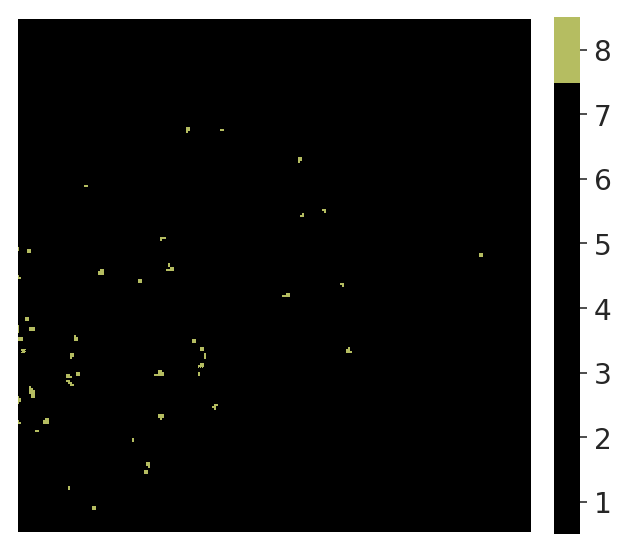

In [344]:
plot_label_image(a.obs['cls_sub_leu'],a.uns['cls_sub_leu_colors'],mask=[7],save=None)


## Different K

### k=4

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

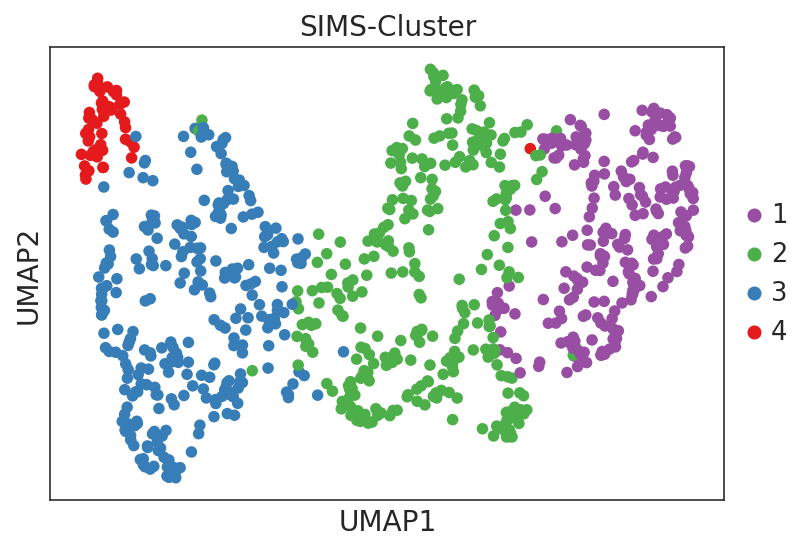

In [346]:
sc.pl.umap(a,color='SIMS-Cluster')

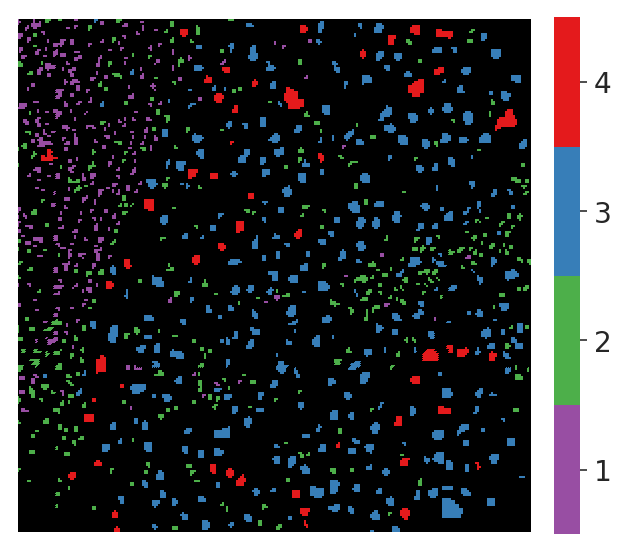

In [348]:
plot_label_image(a_test.obs['SIMS-Cluster'],a_test.uns['SIMS-Cluster_colors'],mask=None)


## k=5

In [350]:
a_ec2 = a[a.obs['SIMS-Cluster'].isin(['1','2'])]

In [428]:
sc.pp.neighbors(a_ec2,use_rep='X_umap')
sc.tl.leiden(a_ec2,resolution=0.12)

# louvain
# mean
# 0.3:2
# 0.7:3
# 1:4

# X_umap
# 0.02:2
# 0.07:3
# 0.1:4
# 0.15:5


# leiden
# 0.02:2
# 0.05:3
# 0.07:4
# 0.1:5
# 0.12:6


computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


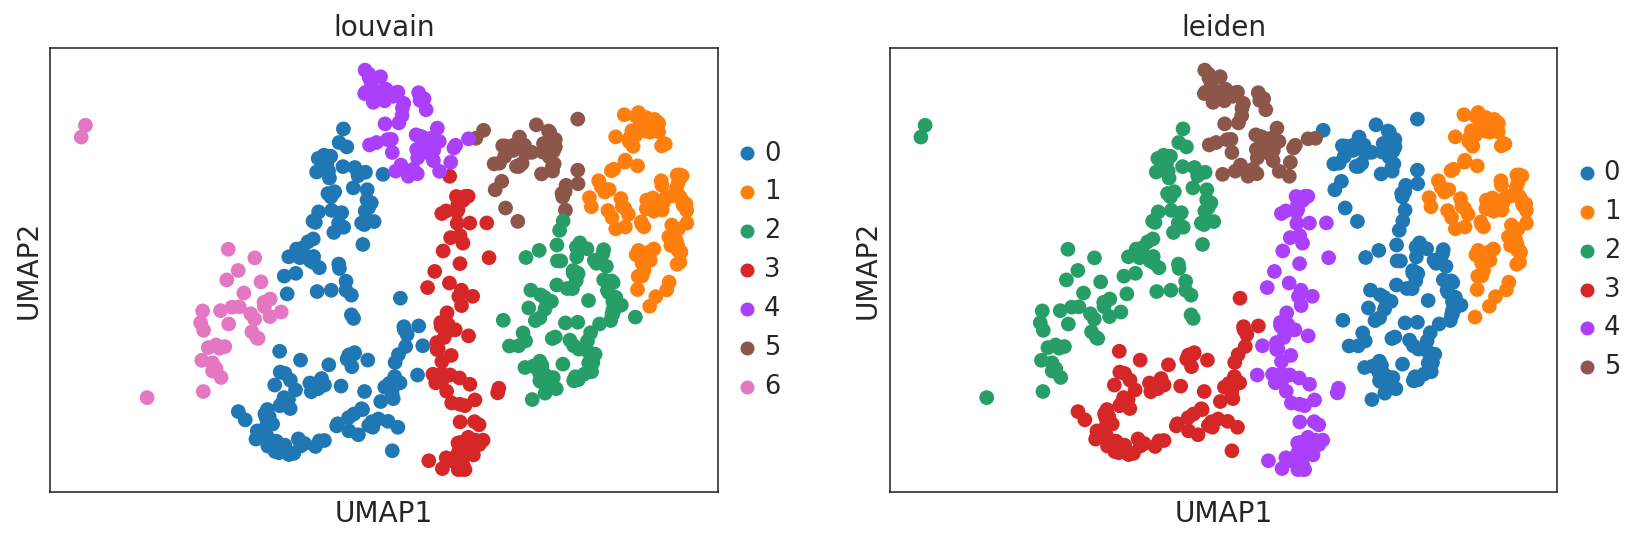

In [429]:
sc.pl.umap(a_ec2,color=['louvain','leiden'])


In [430]:
sc.tl.rank_genes_groups(a_ec2,groupby='leiden')


ranking genes
    finished (0:00:00)


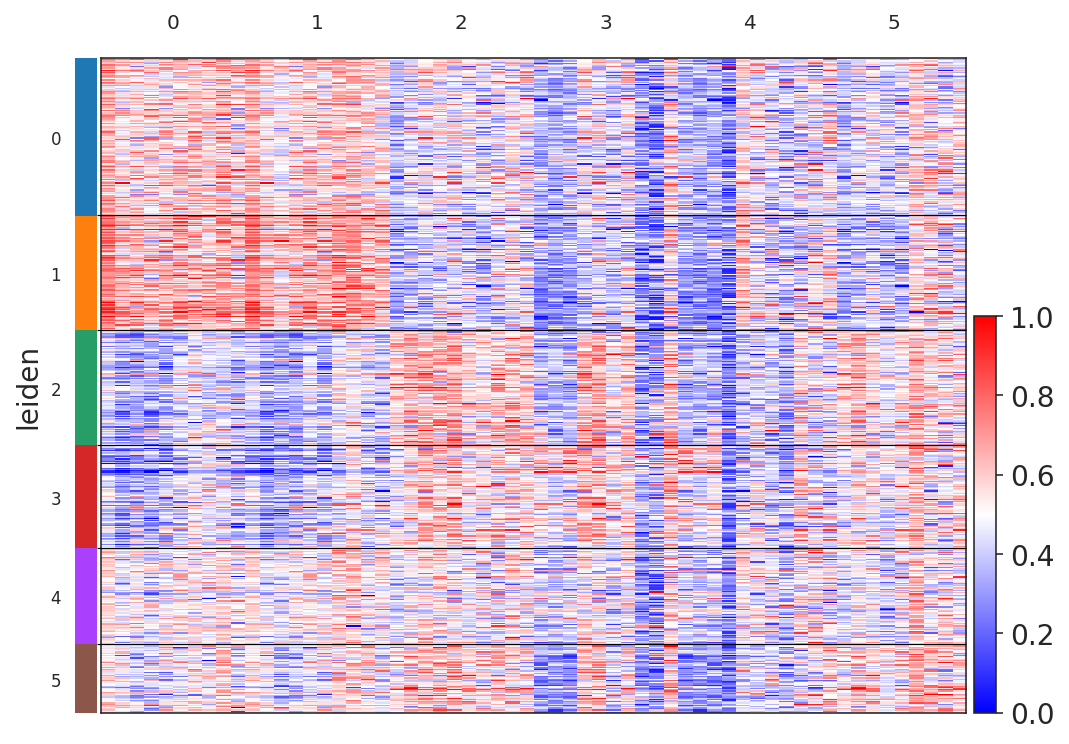

In [431]:
sc.tl.rank_genes_groups(a_ec2,groupby='leiden')

sc.pl.rank_genes_groups_heatmap(a_ec2,groupby='leiden',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [432]:
a_cls_sub = np.array(a.obs['SIMS-Cluster'])
ec_cls = np.array(a_ec2.obs['leiden'])
to_replace_cls = ['1','2']
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)
a.obs['cls_5'] = a_cls_sub_modified
a.obs['cls_5'] = a.obs['cls_5'].astype('category')


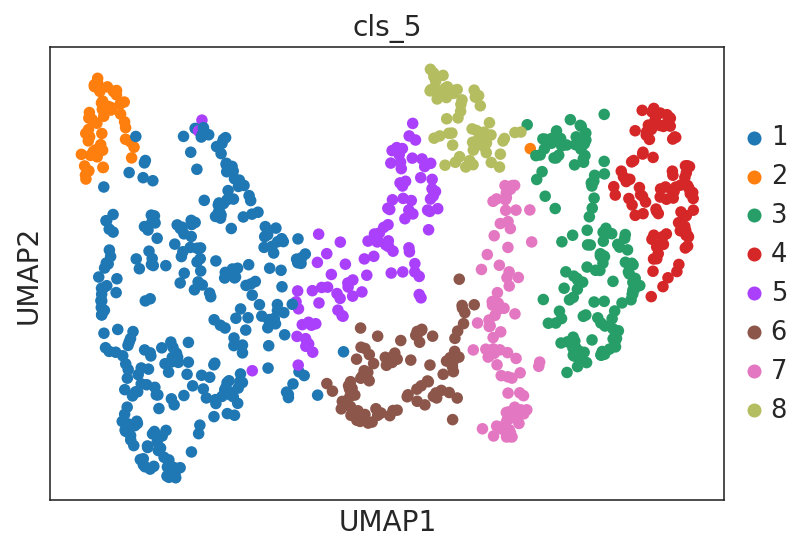

In [433]:
sc.pl.umap(a,color='cls_5')

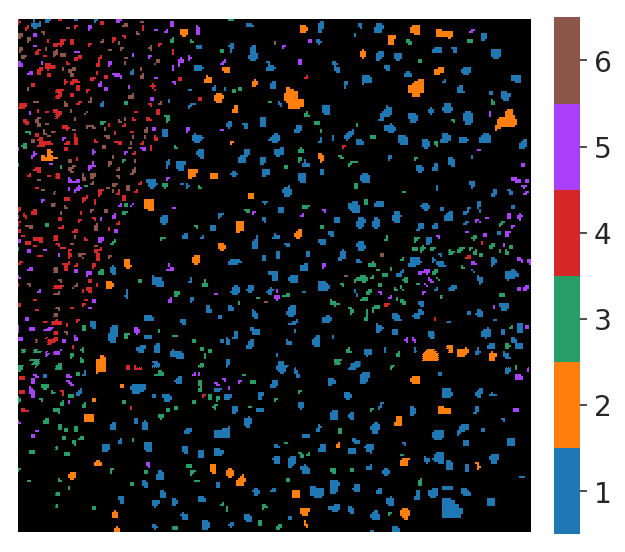

In [390]:
plot_label_image(a.obs['cls_5'],a.uns['cls_5_colors'],mask=None)


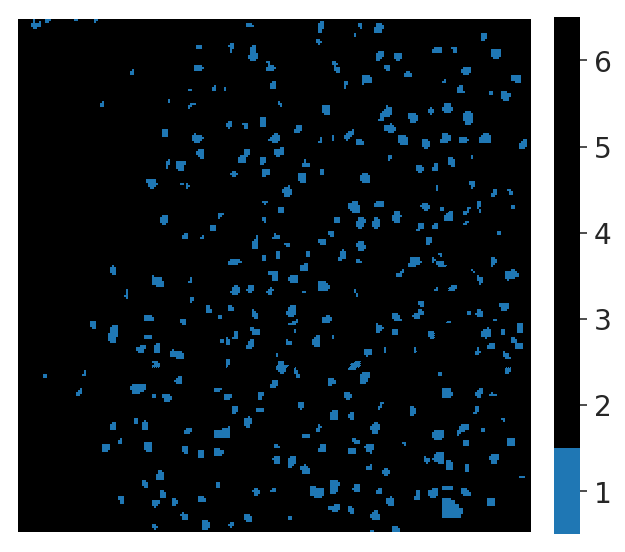

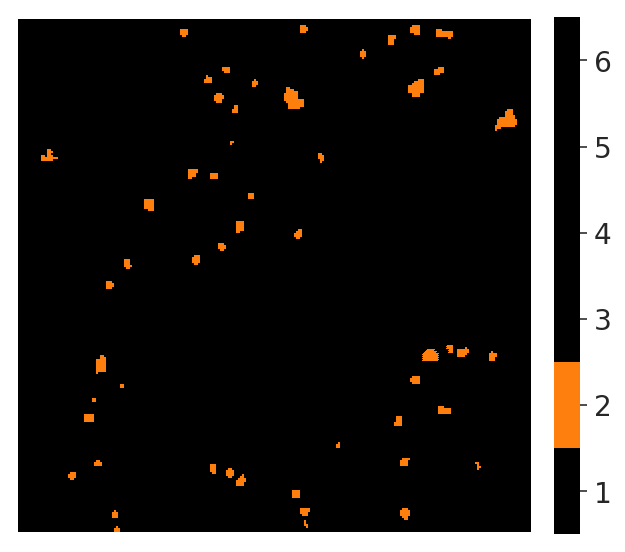

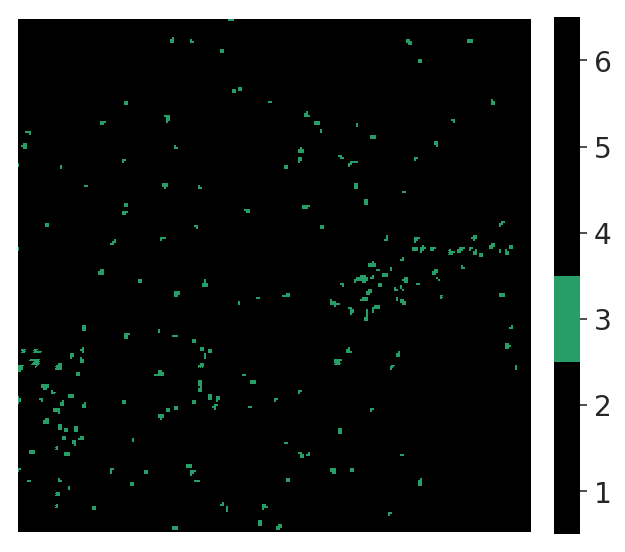

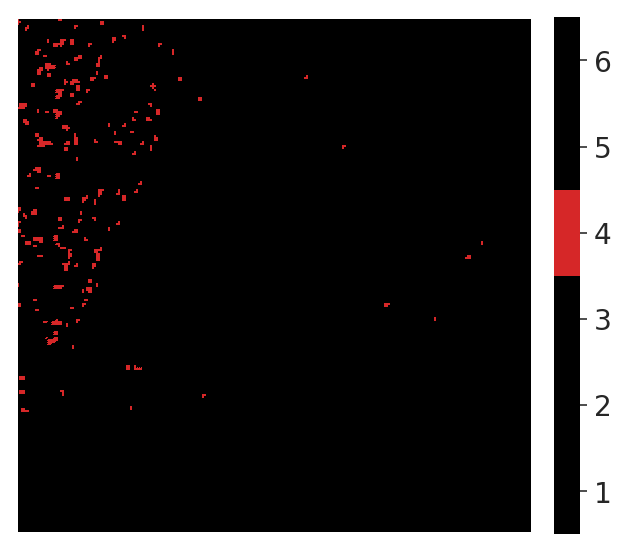

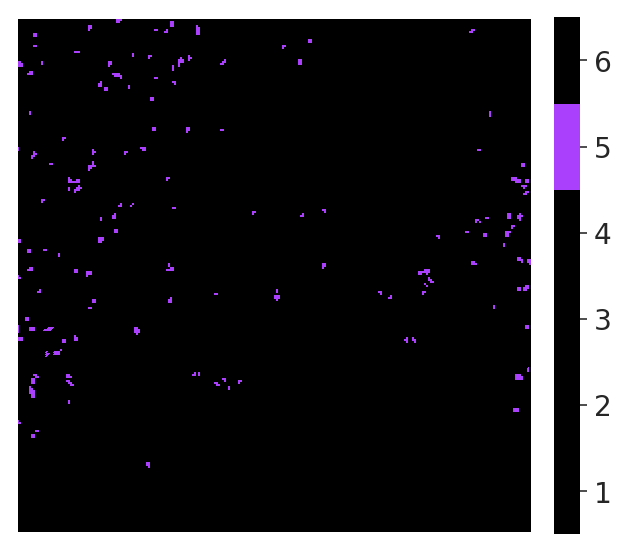

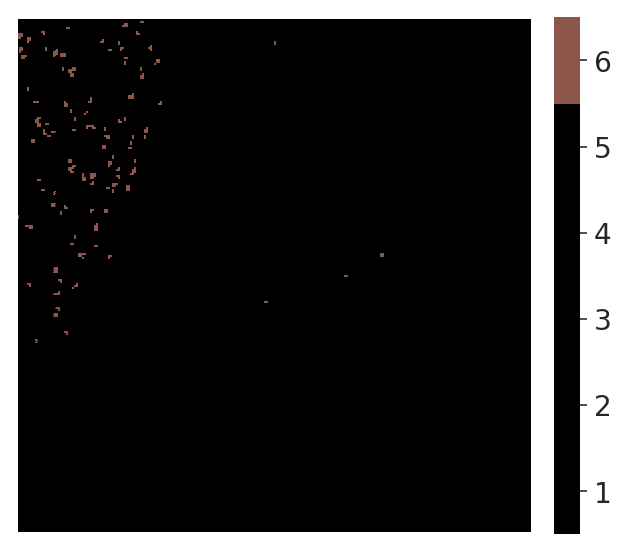

In [391]:
for i in range(6):
    plot_label_image(a.obs['cls_5'],a.uns['cls_5_colors'],mask=[i])
    

In [502]:
sc.pp.neighbors(a,use_rep='X_umap')
sc.tl.leiden(a,resolution=0.07)
# 0.07:5
# 0.1:6
# 0.105:7
# 0.11:8

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

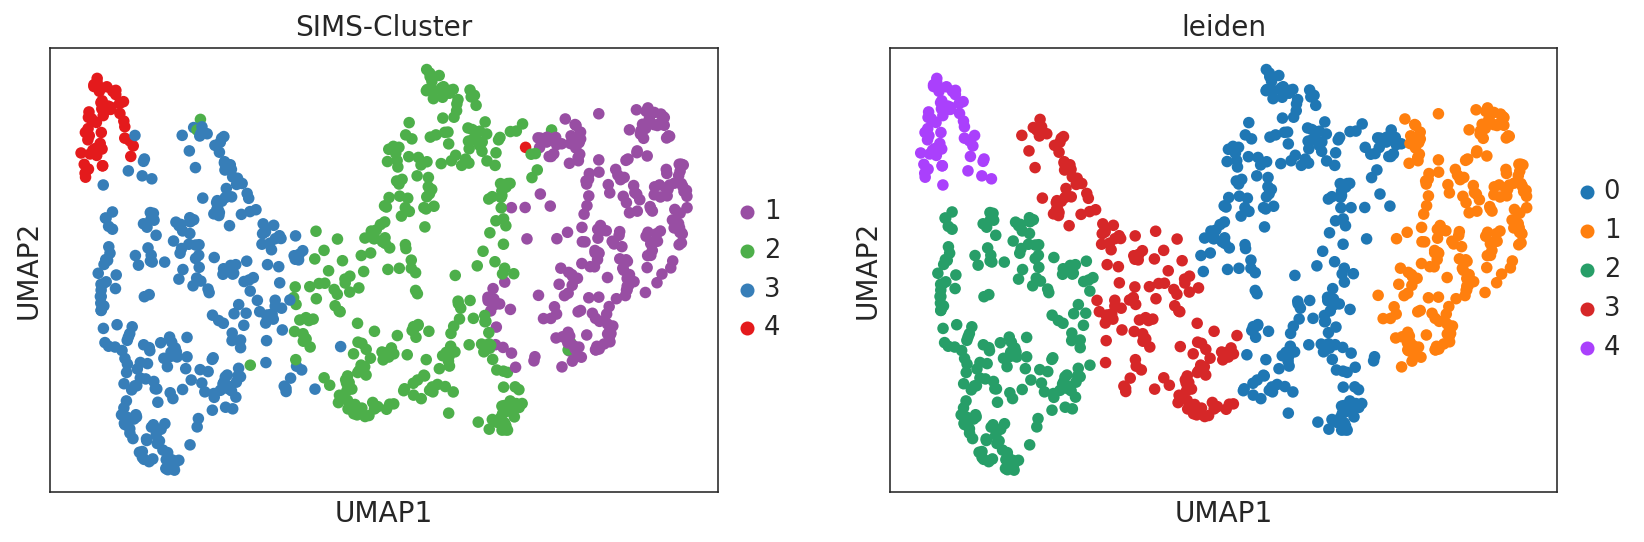

In [503]:
sc.pl.umap(a,color=['SIMS-Cluster','leiden'])

In [472]:
np.unique(a.obs['louvain'])

array(['0', '1', '2', '3', '4', '5'], dtype=object)

In [458]:
a.uns['louvain_colors']

['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b']

In [457]:
a.uns['leiden_colors']

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8']

In [479]:
tmp_cmp = palettable.colorbrewer.qualitative.Set1_6.mpl_colors

In [504]:
a.uns['leiden_colors'] = palettable.colorbrewer.qualitative.Set1_5.mpl_colors

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

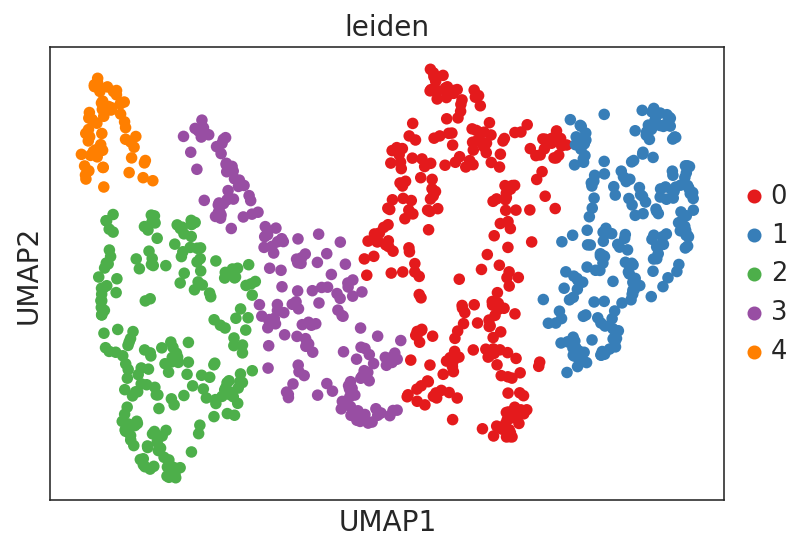

In [505]:
sc.pl.umap(a,color=['leiden'])

ranking genes
    finished (0:00:00)


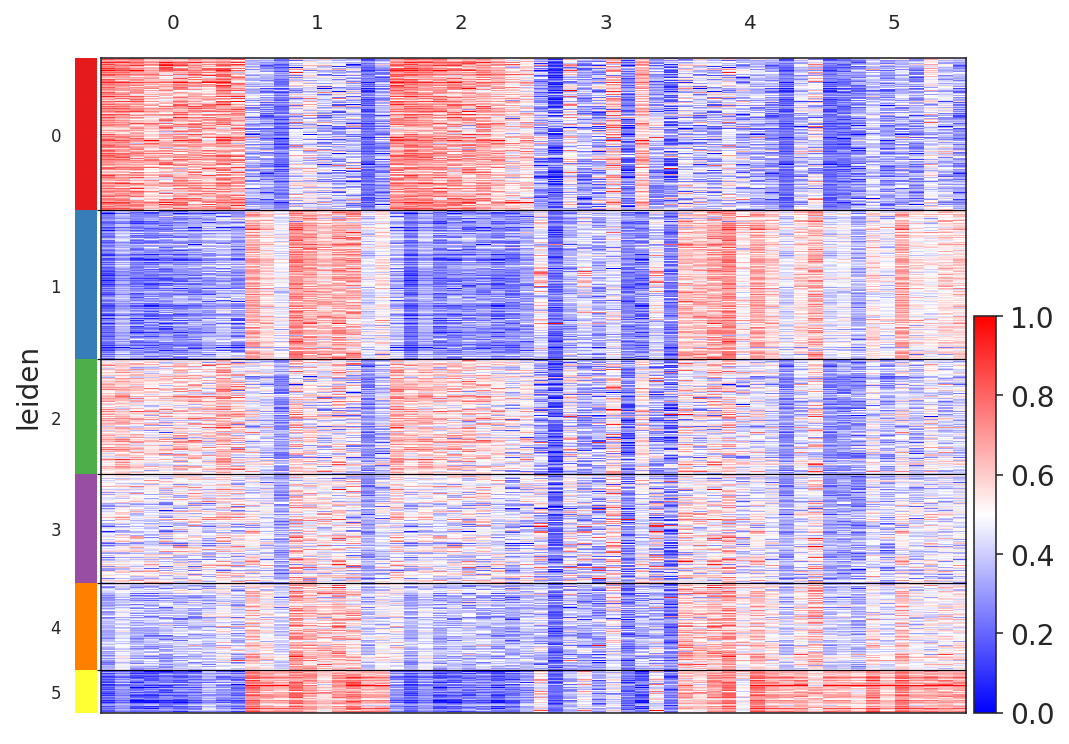

In [496]:
sc.tl.rank_genes_groups(a,groupby='leiden')
sc.pl.rank_genes_groups_heatmap(a,groupby='leiden',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


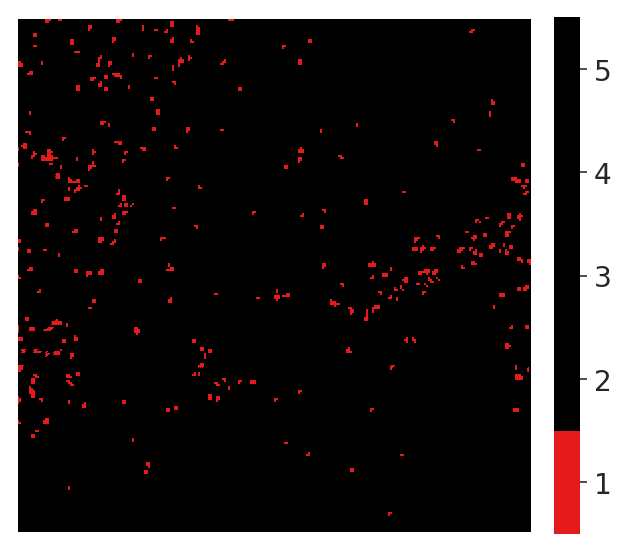

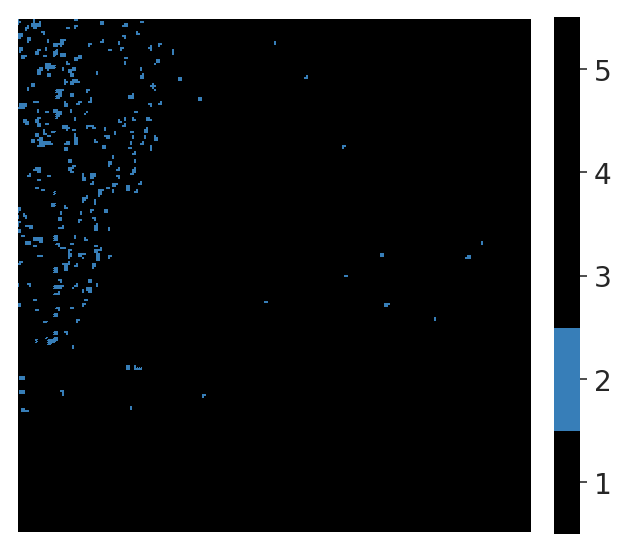

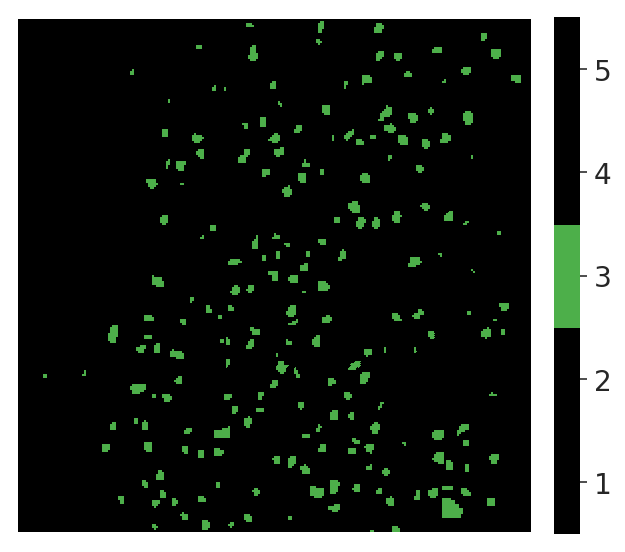

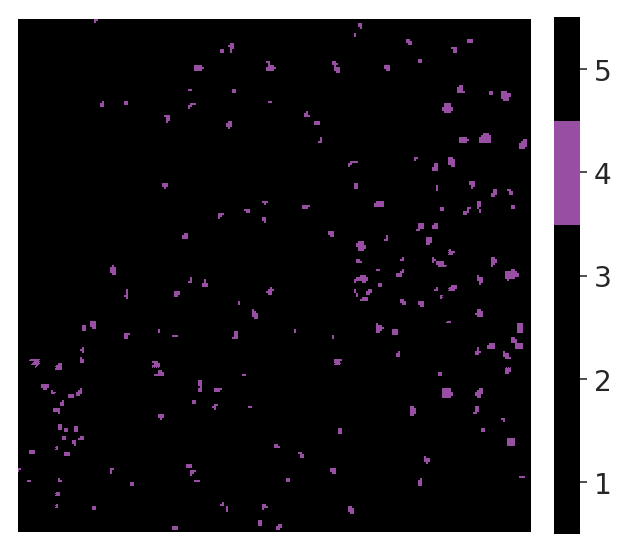

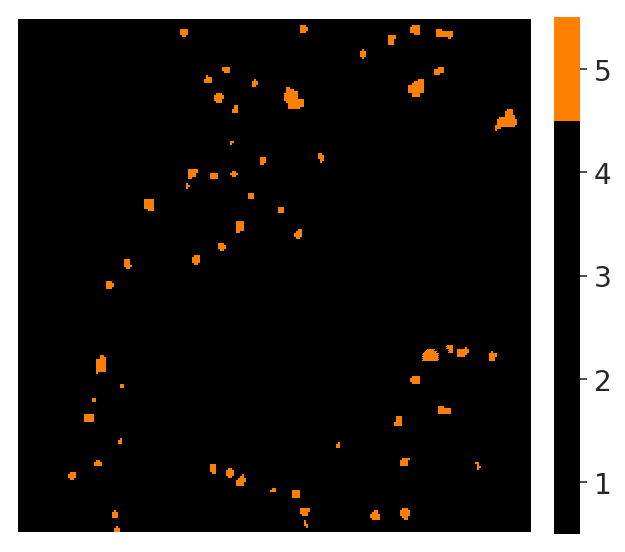

In [506]:
for i in range(5):
    plot_label_image(a.obs['leiden'],a.uns['leiden_colors'],mask=[i])
    

In [357]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    to_replace_cls = np.array(to_replace_cls).astype('int')
    for i in to_replace_cls:
        
        a_cls_sub_int[a_cls_sub_int==int(i)] = -1
        a_cls_sub_int[a_cls_sub_int>int(i)]-=1
        to_replace_cls[to_replace_cls>i]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [356]:
1+1

2

# save anndata

In [140]:
a.write('figures/Fig2/c4/fig2_c4.h5py')

In [225]:
a.write('figures/Fig4_dump_data/fig4_csub.h5ad')

In [226]:
a_test = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig4_dump_data/fig4_csub.h5ad')


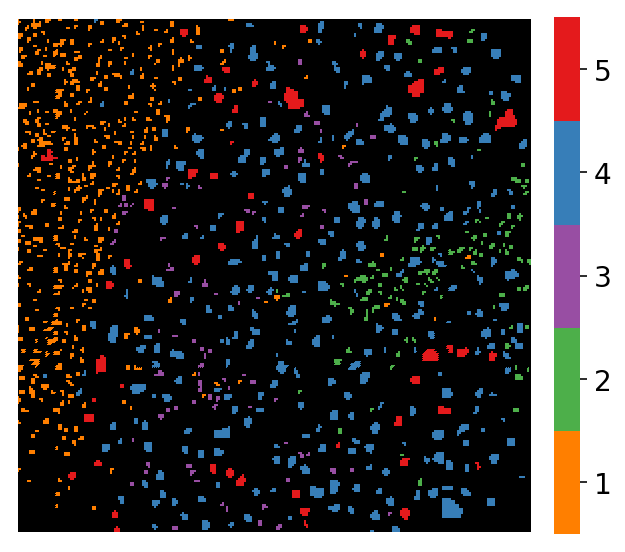

In [227]:
plot_label_image(a_test.obs['cls_sub'],a_test.uns['cls_sub_colors'],mask=[0,1,2,3,4])


In [229]:
1+1

2